# Botify - Spotify Playlist Processing and Visualization

## Spotify API Access Token Retrieval and Spotipy

The authentication process with Spotify API starts by creating an authorization URL that directs the user to a login page. This URL comprises components such as `response_type`, `redirect_uri`, `scope`, and `client_id`. To build the authorization URL, these parameters are encoded using `urllib.parse.quote` and combined into a single URL.

Once the user visits the authorization URL and logs in, the process becomes mostly automated. Spotify provides an `authorization_code`, which is essential for the next step of the authentication process—requesting an access token.

To request the access token, an HTTP POST request is sent to the generated Spotify token URL. Once the `authorization_code` is successfully validated, the user obtains essential data, including the access token and refresh token.

This particular user authentication grant flow is necessary for each individual user. It enables access to someone's Liked Songs or allows modifications to their playlist library.

In [ ]:
import requests
import json
import configparser
from urllib.parse import quote
import time
import warnings
warnings.filterwarnings('ignore')

config = configparser.ConfigParser()
config.read('config.ini')

USERNAME = config.get('SPOTIFY', 'username')
PASSWORD = config.get('SPOTIFY', 'password')
CLIENT_ID = config.get('SPOTIFY', 'client_id')
CLIENT_SECRET = config.get('SPOTIFY', 'client_secret')
REDIRECT_URI = config.get("SPOTIFY", 'redirect_uri')
SCOPE = config.get('SPOTIFY', 'scope')

SPOTIFY_AUTH_URL = "https://accounts.spotify.com/authorize"
SPOTIFY_TOKEN_URL = "https://accounts.spotify.com/api/token"
SPOTIFY_API_BASE_URL = "https://api.spotify.com"
API_VERSION = "v1"
SPOTIFY_API_URL = "{}/{}".format(SPOTIFY_API_BASE_URL, API_VERSION)

auth_query_parameters = {
    "response_type":"code",
    "redirect_uri": REDIRECT_URI,
    "scope": SCOPE,
    "client_id": CLIENT_ID,
}

url_args="&".join(["{}={}".format(key, quote(val)) for key, val in auth_query_parameters.items()])
auth_url="{}/?{}".format(SPOTIFY_AUTH_URL, url_args)

print(f"Authorization URL: {auth_url}")

input_url = input("Please paste the URL you were redirected to after authorizing the app: ")

authorization_code = input_url.split("code=")[-1].split("&")[0]
print(f"Authorization code: {authorization_code}")


access_token_request_url = SPOTIFY_TOKEN_URL
access_token_request_data = {
    "grant_type": "authorization_code",
    "code": authorization_code,
    "redirect_uri": REDIRECT_URI,
    "client_id": CLIENT_ID,
    "client_secret": CLIENT_SECRET,
}

print(f"Access token request URL: {access_token_request_url}")
print(f"Access token request data: {access_token_request_data}")

response = requests.post(access_token_request_url, data=access_token_request_data)

response_data = json.loads(response.text)

print(f"Response data: {response_data}")

access_token = response_data["access_token"]
refresh_token = response_data["refresh_token"]
token_type = response_data["token_type"]
expires_in = response_data["expires_in"]

print(f"Access token: {access_token}")

Authorization URL: https://accounts.spotify.com/authorize/?response_type=code&redirect_uri=http%3A//rawcsav.com&scope=user-read-private%20user-read-email%20playlist-modify-private%20ugc-image-upload%20user-library-modify&client_id=a7736df74b5e4fd19b696881709023ba


## Using Spotipy Library for Spotify Web API Interaction

This section utilizes the `Spotipy` library, a Python wrapper designed specifically for interacting with the Spotify Web API. We connect to the Spotify API using the `client_credentials_manager`, which enables direct access to a specific playlist through its URI and ID. This code is simpler to execute than the previous method, as it does not require obtaining user-specific authorization and, thus, cannot access private user data or perform actions on behalf of a user. This approach is useful for solely analyzing Spotify tracks and their track data without the need to make modifications.

In [115]:
import pandas as pd
from tqdm import tqdm
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
from pprint import pprint
import requests
import concurrent.futures
import json
import configparser
from urllib.parse import quote
import time

config = configparser.ConfigParser()
config.read('config.ini')

USERNAME = config.get('SPOTIFY', 'username')
PASSWORD = config.get('SPOTIFY', 'password')
CLIENT_ID = config.get('SPOTIFY', 'client_id')
CLIENT_SECRET = config.get('SPOTIFY', 'client_secret')
REDIRECT_URI = config.get('SPOTIFY', 'redirect_uri')
SCOPE = config.get('SPOTIFY', 'scope')
SPOTIFY_API_KEY = config.get('SPOTIFY','spotify_api_key')

SPOTIFY_AUTH_URL = "https://accounts.spotify.com/authorize"
SPOTIFY_TOKEN_URL = "https://accounts.spotify.com/api/token"
SPOTIFY_API_BASE_URL = "https://api.spotify.com"
API_VERSION = "v1"
SPOTIFY_API_URL = "{}/{}".format(SPOTIFY_API_BASE_URL, API_VERSION)

client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

uri = 'spotify:playlist:662StmFnG83CfpdygiWmeJ'
playlist_id = '662StmFnG83CfpdygiWmeJ'

## Retrieving Playlist Tracks and Extracting Data

In this section, the script retrieves the playlist tracks using the `sp.playlist_tracks()` method and the existing `playlist_id`. Since a playlist might have more tracks than initially returned by the API, the script iterates through the 'next' pages of results using the `sp.next()` method until no more pages are available. All retrieved tracks are extended into the 'tracks' list.

A list of column names is created to represent the data extracted from each track. As this part of the code serves as the foundation for securing Spotify backend IDs used later, it is important to skip any song that is not in the Spotify streaming library and is only a local file.

In this specific case, we'll be saving some crucial information that can be extracted solely from the track data: title, release_date, artists, album, popularity, duration, explicit, track_id, and artist_ids.

- 'Artists': A list of strings for all artists on a given song.
- 'Popularity': A scale of 1-100 representing the popularity of a given song.
- 'Explicit': A boolean value (True or False) indicating if a song contains explicit lyrics.

In [116]:
import pandas as pd

results = sp.playlist_tracks(playlist_id)
tracks = results['items']
while results['next']:
    results = sp.next(results)
    tracks.extend(results['items'])
    
columns = ['title', 'release_date', 'artists', 'album', 'popularity', 'genres', 'duration', 'explicit', 'track_id', 'artist_ids']
rows = []

for track in tqdm(tracks):
    artist_ids = []
    if track['is_local'] or track['track'] is None or track['track']['is_local']:
        continue
    track_name = track['track']['name']
    release_date = track['track']['album']['release_date']
    artists = ', '.join([artist['name'] for artist in track['track']['artists']])
    album = track['track']['album']['name']
    popularity = track['track']['popularity']
    duration = track['track']['duration_ms']
    explicit = track['track']['explicit']
    track_id = track['track']['id']
    for artist in track['track']["artists"]:
        artist_ids.append(artist["id"])
    rows.append({'title': track_name, 'release_date': release_date, 'artists': artists, 'album': album, 'popularity': popularity, 'duration': duration, 'explicit': explicit, 'track_id': track_id, 'artist_ids': artist_ids,})

df = pd.DataFrame(rows, columns=columns)
df.info()


100%|███████████████████████████████████| 1949/1949 [00:00<00:00, 209634.53it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1756 entries, 0 to 1755
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         1756 non-null   object 
 1   release_date  1756 non-null   object 
 2   artists       1756 non-null   object 
 3   album         1756 non-null   object 
 4   popularity    1756 non-null   int64  
 5   genres        0 non-null      float64
 6   duration      1756 non-null   int64  
 7   explicit      1756 non-null   bool   
 8   track_id      1756 non-null   object 
 9   artist_ids    1756 non-null   object 
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 125.3+ KB


## Fetching Audio Features and Extending DataFrame

This code excerpt focuses on fetching audio features for each track in the dataframe created previously and extending the dataframe with the new information. First, the script extracts the `track_ids` and initializes an empty list called `audio_features` and an index variable to keep track of the position in the `ids` list.

Since Spotify's API has a set limit of 50 ids per request, the script iterates in batches of 50 ids every time. It calls `sp.audio_features()` and appends the returned audio features to the 'audio_features' list. The loop continues until all track_ids have their audio features fetched. The script then iterates through the this list in order to extract the relevant attributes. In our case: energy, liveness, tempo, speechiness, acousticness, instrumentalness, time_signature, danceability, key, loudness, valence, and mode. 

A new pandas DataFrame called `features_df` is then created using the `features_list`, with the specified column names. The 'features_df' is then merged with the original dataframe (df) based on the `track_id` column.

The following are some descriptions of these features as described by Spotify:

- Acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.<br>
<br>
- Danceability: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.<br>
<br>
- Energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.<br>  
<br>
- Instrumentalness: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.<br>  
<br>
- Key: The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.<br>  
<br>
- Liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.<br>  
<br>
- Loudness: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 dB.<br>
<br>
- Mode: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.<br>
<br>
- Tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.<br>  
<br>
- Time_signature: An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".<br>  
<br>
- Speechiness: Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer the attribute value is to 1.0, while values close to 0 indicate music or non-speech tracks.<br>  
<br>
- Valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. High valence tracks sound more positive (e.g., happy, cheerful, euphoric), while low valence tracks sound more negative (e.g., sad, depressed, angry).  

In [117]:
ids = df['track_id'].tolist()
index = 0
audio_features = []
while index < len(ids):
    audio_features += sp.audio_features(ids[index:index + 50])
    index += 50
features_list = []
for idx, features in enumerate(audio_features):
    features_list.append([
                ids[idx],
                features['energy'], features['liveness'],
                features['tempo'], features['speechiness'],
                features['acousticness'], features['instrumentalness'],
                features['time_signature'], features['danceability'],
                features['key'],
                features['loudness'], features['valence'],
                features['mode']])

features_df = pd.DataFrame(features_list, columns=['track_id','energy', 'liveness',
                                              'tempo', 'speechiness',
                                              'acousticness', 'instrumentalness',
                                              'time_signature', 'danceability',
                                              'key', 'loudness',
                                              'valence', 'mode',])
df = df.merge(features_df, on='track_id')
df.sample(5)

,title,release_date,artists,album,popularity,genres,duration,explicit,track_id,artist_ids,...,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,loudness,valence,mode
1243,Dmtri,2019-11-22,"Action Bronson, The Alchemist",Lamb Over Rice,53,NaN,274133,True,1CEVg3GpmapQ5rK5feHbFc,"[7BMccF0hQFBpP6417k1OtQ, 0eVyjRhzZKke2KFYTcDkeu]",...,81.024,0.478,0.6740,0.000000,4,0.599,9,-6.290,0.300,0
1735,buku,2023-03-10,wolfacejoeyy,buku,59,NaN,137691,True,7eOAf1CKZenIfLyaV01MgX,[7LjXznzJeKuvjRbNcBWd6Z],...,139.984,0.209,0.8130,0.001450,4,0.645,1,-8.633,0.534,1
183,Evil Fantasy,2018-01-08,Freddie Dredd,Evil Fantasy,58,NaN,114128,True,3A4TIpLeMng0Nn0N7yre4g,[0dlDsD7y6ccmDm8tuWCU6F],...,80.028,0.316,0.2200,0.000321,4,0.855,5,-5.976,0.655,1
313,BIG,2019-09-27,Young M.A,Herstory in the Making,64,NaN,225919,True,7cyeGclH71MayOuQ7qtLFl,[7LvoDJUNGnOrPdGRzVtOJ9],...,85.005,0.369,0.0408,0.000006,4,0.860,0,-5.776,0.150,0
1475,Mob Shit,2022-08-04,Warhol.SS,3PEAT - EP,24,NaN,142368,True,21RvkkYHi4ApQeWCaR2J0n,[3O7mUqVuHmLJqHXbFiQY62],...,148.043,0.296,0.0684,0.000000,4,0.712,11,-4.538,0.830,0


## Fetching Genres Associated with Each Track

Moving forward, the goal here is to fetch the genres associated with each track, however Spotify does not provide genres for specific tracks, only for their artists. This works well enough for me. 

To fetch the genres, the script iterates through the previously saved 'artist_ids' column of the dataframe using tqdm for progress tracking. A temporary `artist_genres` list is created to store the genres of all artists linked to a particular track. The script processes artist_ids in batches of 50 to avoid the set limit, and, for each batch, it makes a request to the Spotify API using `sp.artists()` and obtains the results as a list of artists. It extracts the 'genres' field from each artist and adds it to the 'artist_genres' list. 

In [118]:
from tqdm import tqdm
import pandas as pd


genres = []
BATCH_SIZE = 50

for artist_id_list in tqdm(df['artist_ids'], desc="Processing artist IDs"):
    artist_genres = []
    
    for i in range(0, len(artist_id_list), BATCH_SIZE):
        batch_artist_ids = artist_id_list[i:i + BATCH_SIZE]
        artist_results = sp.artists(batch_artist_ids)['artists']
        
        for artist in artist_results:
            artist_genres.extend(artist['genres'])
    
    genres.append(', '.join(artist_genres))

df['genres'] = genres
df.sample(5)

Processing artist IDs: 100%|████████████████| 1756/1756 [05:24<00:00,  5.40it/s]


,title,release_date,artists,album,popularity,genres,duration,explicit,track_id,artist_ids,...,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,loudness,valence,mode
1519,Crime Story,1999-06-22,Shyheim,Manchild,14,"hardcore hip hop, wu fam",281600,True,4EJJKWY89WxPhqDddB5iA0,[0rqb5s3Cxj0lGr6jTrWc0P],...,88.051,0.3190,0.5330,0.0000,4,0.570,7,-6.016,0.743,1
1157,Play Em Like Atari,2022-02-10,Drain Gang Archive,Play Em Like Atari,49,drain,229353,False,34uzB2MBbxtrXMhYPUfz2g,[1NZYxkl40ebW2QiwkMctIY],...,120.020,0.0567,0.5320,0.0029,4,0.450,7,-9.794,0.111,1
1532,Paranormal Snaptivity,2021-07-20,"Zelooperz, RX Nephew, Quadie Diesel",Van Goghs Left Ear,30,"alternative hip hop, detroit hip hop, indie hi...",163747,True,67dAJ7uV2yPgElWGztOjJF,"[5j93hwFBNo29RJMsWvtzj8, 7f3pexehhZwFV05N3csJY...",...,169.143,0.3350,0.0169,0.0000,4,0.584,1,-6.183,0.177,0
1509,Last Dayz (S.i.p Willie & Bogle),2021-08-17,Sickboyrari,Chain Gang Halo World,30,"glitchcore, underground hip hop, vapor trap",143404,True,4TGKToBI1GE3AH07TVixZt,[395BAMokcNaqWcCl8uU1ky],...,79.201,0.2850,0.2960,0.0018,4,0.444,6,-10.337,0.863,1
1705,Oh Lord,2022-02-02,iayze,The Leek 4!,43,plugg,89216,True,536W1SryvhPjW4YjxVg9zA,[00msLVGU9crX0EC5McCiCa],...,140.132,0.0942,0.3640,0.0000,4,0.575,7,-10.456,0.342,0


## Fetching Lyrics for Tracks Using Genius and MusixMatch APIs

This code excerpt symbolizes the last point in the actual gathering of numerical and textual data for the songs. The code here attempts to fetch lyrics for all the tracks in the dataframe. It combines two different lyrical APIs: *Genius* and *MusixMatch*. You would not believe the amount of pure crap can get turned up by simple lyrical site scraping using the official APIs, so it was necessary to implement a multiple part fail-safe in order to maximize the quantity of lyrics scraped without any external interference in the results.

This process was also very long and very taxing on both my internet and the lyrical API services, so I've implemented a combination of both batching, as seen previously, and the `concurrent.futures` module. This module allows for individual processes to be assigned to threads that will work on individual tasks concurrently.

This was such an involved process that I decided to define all functions beforehand.

I start first by defining a dictionary for the lyrics, therefore as a song is searched for lyrics, the results will be placed into the dictionary regardless of success or not. This is so that if there is a error or need to restart, the code will go through the dictionary as it's source; only searching for songs without inputted lyrical entries.

The main functions in the script, `get_lyrics(row)` and `search_song(title, artists)`, search for and retrieve lyrics by interacting with the APIs. The `get_lyrics(row)` function first tries to find lyrics using the *Genius* API and then utilizes a fallback within the *Musixmatch* API. The *Musixmatch* API is meh, so I did not prioritize it, but it found a select few that *Genius* couldn't. Overall, I employ fuzzy string matching with with a required ratio of greater than 70% for both the track title and track artists. This was specifically implemented because *Genius* kept returning extremely noisy and irrelevant data due to selection of the wrong song in the search results. The `search_song(title, artists)` function actually searches for the song on *Genius* and returns the matched song object if it exists.

In [1]:
import re
import csv
import pandas as pd
from lyricsgenius import Genius
import configparser
import musixmatch
from fuzzywuzzy import fuzz
from tqdm import tqdm
import requests
import concurrent.futures


config = configparser.ConfigParser()
config.read('config.ini')
GENIUS_API_KEY = config.get("LYRICS", "GENIUS_API_KEY")
MUSIX_API_KEY = config.get("LYRICS", "MUSIX_API_KEY")
genius = Genius(GENIUS_API_KEY, verbose=False, retries=5, timeout=10)

lyrics_dict = {}

def remove_parentheses(text):
    if not isinstance(text, str):
        return ''
    return re.sub(r'\([^)]*\)', '', text).strip()

def get_lyrics(row):
    title = remove_parentheses(row["title"])
    all_artists = [artist.strip() for artist in row["artists"].split(",")] if isinstance(row["artists"], str) else [] 
    
    for artist in all_artists:
        if (title, artist) in lyrics_dict:
            return lyrics_dict[(title, artist)]

        song = genius.search_song(title, artist)
        if song is not None and len(song.lyrics) >= 20:
            title_ratio = fuzz.token_set_ratio(title, song.title)

            genius_artists = [genius_artist.strip() for genius_artist in song.artist.split(",")]

            artist_matched = False
            for genius_artist in genius_artists:
                artist_ratio = fuzz.token_set_ratio(artist, genius_artist)
                if artist_ratio >= 70:
                    artist_matched = True
                    break

            if title_ratio >= 70 and artist_matched:
                lyrics_dict[(title, artist)] = song.lyrics
                return song.lyrics

    for artist in all_artists:
        if (title, artist) in lyrics_dict:
            return lyrics_dict[(title, artist)]

        response = requests.get(f"https://api.musixmatch.com/ws/1.1/matcher.lyrics.get?q_track={title}&q_artist={artist}&apikey={MUSIX_API_KEY}")
        data = response.json()

        if data["message"]["header"]["status_code"] == 200:
            lyrics = data["message"]["body"]["lyrics"]["lyrics_body"]
            if len(lyrics) > 0:
                lyrics_dict[(title, artist)] = lyrics
                return lyrics

    print(f"No lyrics found for {title} by {', '.join(all_artists)}")
    lyrics_dict[(title, artist)] = "lyrics not found"
    return "lyrics not found"

def process_batch(batch):
    batch["lyrics"] = batch.apply(get_lyrics, axis=1)
    return batch

def sanitize_text(text):
    if not isinstance(text, str):
        return text

    text = re.sub(r" - .*", "", text)
    text = re.sub(r" Remastered.*", "", text)
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"\(.*?\)", "", text)
    text = re.sub(r"(?i)\b(ft|feat(?:\.|uring)?)(?:.*)", "", text)
    text = re.sub(r'[^a-zA-Z0-9 \n]', '', text)

    return text.strip()

def check_song_match(song, title, artists):
    if song is not None and len(song.lyrics) >= 20:
        title_ratio = fuzz.token_set_ratio(title, song.title)
        genius_artists = [genius_artist.strip() for genius_artist in song.artist.split(",")]

        max_individual_artist_ratio = max(
            fuzz.token_set_ratio(artist, genius_artist)
            for artist, genius_artist in product(artists, genius_artists)
        )
        combined_artist_ratio = fuzz.token_set_ratio(", ".join(artists), ", ".join(genius_artists))

        if title_ratio >= 70 and (max_individual_artist_ratio >= 70 or combined_artist_ratio >= 70):
            return True
    return False

def search_song(title, artists):
    song = genius.search_song(title, ", ".join(artists))

    if not check_song_match(song, title, artists) and len(artists) > 1:
        for artist in artists:
            song = genius.search_song(title, artist)
            if check_song_match(song, title, [artist]):
                break

    return song

def get_lyrics_for_row(row):
    title = row['title']
    artists = row['artists'].split(', ')
    lyrics = row['lyrics']

    if pd.isnull(lyrics) or lyrics == "lyrics not found" or len(lyrics.split()) < 30 or lyrics.isdigit():
        song = search_song(title, artists)
        if check_song_match(song, title, artists):
            return song.lyrics
        else:
            return "lyrics not found"

    return lyrics

def get_lyrics_batch(df):
    return df.apply(get_lyrics_for_row, axis=1)

def get_lyrics_batch_with_sanitization(df):
    def get_lyrics_for_row_with_sanitization(row):
        title = sanitize_text(row['title'])
        artists = [sanitize_text(artist) for artist in row['artists'].split(', ')]
        lyrics = row['lyrics']

        if pd.isnull(lyrics) or lyrics == "lyrics not found" or len(lyrics.split()) < 30 or lyrics.isdigit():
            song = search_song(title, artists)
            if check_song_match(song, title, artists):
                return song.lyrics
            else:
                return "lyrics not found"

        return lyrics

    return df.apply(get_lyrics_for_row_with_sanitization, axis=1)

## Song Lyrics Searching and Validation Process

This is extremely convoluted and it still stresses me out to look at, but I'll attempt to explain the general logical flow of how the code works.
- It first searches for all the songs on *Genius* without any [] in the name as these were a common cause for false negatives originally.
- It first checks if the song is in the dictionary, if it is not then it searches for it on *Genius*, if there is a match with over 20 words it then sees if the title of the song and the song's artists on *Genius* have at least a 70% fuzzy similarity score.
- If they do not then it is passed over. Songs that are passed over are then sent to *MusixMatch* where an attempt to find lyrics is made, but they were often passed from this point as well.
- If lyrics are passed, their lyrics value is set to "lyrics not found."

Moving forward, we use this "lyrics not found" in a more general scope as we specifically search for songs that have either null, empty strings, all digits, or have a word count less than 30 in their lyrics column. Thus, we search for passed songs/potential error cases again but in 2 different ways:
- without any modifications made to the song title or artist name's, and
- then a second time with heavy sanitization applied to both.

For these secondary checks, fuzzy string ratios still applied but we did not query *MusixMatch* at all.

In [122]:
import re
import pandas as pd
from itertools import product
from fuzzywuzzy import fuzz
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

batch_size = 20
batches = [df[i:i+batch_size] for i in range(0, len(df), batch_size)]

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_batch, batches), total=len(batches)))

df = pd.concat(results)

batch_size = 20
n_batches = int(len(df) / batch_size) + 1

with tqdm(total=n_batches) as pbar:
    with ThreadPoolExecutor() as executor:
        for i in range(n_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            df.loc[start:end, 'lyrics'] = executor.submit(get_lyrics_batch, df.loc[start:end]).result()
            pbar.update(1)

batch_size = 20
n_batches = int(len(df) / batch_size) + 1

with tqdm(total=n_batches) as pbar:
    with ThreadPoolExecutor() as executor:
        for i in range(n_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            missing_lyrics_rows = df.loc[start:end][df.loc[start:end, 'lyrics'].isna() | (df.loc[start:end, 'lyrics'].str.len() < 20) | (df.loc[start:end, 'lyrics'].str.isdigit())]
            new_lyrics = executor.submit(get_lyrics_batch_with_sanitization, missing_lyrics_rows).result()
            missing_lyrics_rows.index = new_lyrics.index
            df.loc[missing_lyrics_rows.index, 'lyrics'] = new_lyrics
            pbar.update(1)

  0%|                                                    | 0/88 [00:00<?, ?it/s]

No lyrics found for Echoes in My Mind by Spooky Black, Wiccaphase
No lyrics found for VENGEANCE | VENGEANCE [FEAT. JPEGMAFIA & ZILLAKAMI | JPEGMAF1A + Z1LLAKAM1] by Denzel Curry, JPEGMAFIA, ZillaKami
No lyrics found for Aahhyeahh by Oliver Francis
No lyrics found for Время Ток by Antoha MC
No lyrics found for Kill Yourself by $uicideboy$
No lyrics found for Soul Doubt by $uicideboy$
No lyrics found for You're Now Tuning Into 66.6 FM With DJ Rapture by $uicideboy$
No lyrics found for Praise The Lord by A$AP Rocky, Skepta
No lyrics found for If You Were to Get What You Deserve, You Would Know What the Bottom of a Tire Tastes Like by $uicideboy$
No lyrics found for Bags by $uicideboy$
No lyrics found for SIRENS | Z1RENZ [FEAT. J.I.D | J.1.D] by Denzel Curry, JID
No lyrics found for Benz Truck by Lil Peep
No lyrics found for Freewave Freestyle 4 by LUCKI


  1%|▍                                         | 1/88 [01:12<1:44:40, 72.19s/it]

No lyrics found for Big Glock Freestyle by Smgsoulja
No lyrics found for WISH FEAT. KIDDO MARV by Denzel Curry, Kiddo Marv
No lyrics found for Suicidal Thoughts - 2005 Remaster by The Notorious B.I.G.
No lyrics found for Way2geekd by Malik
No lyrics found for Pursuit Of Happiness by Kid Cudi, MGMT, Ratatat
No lyrics found for Tiktok by Spliflort


 15%|██████▎                                    | 13/88 [01:50<08:41,  6.96s/it]

No lyrics found for Bean  [feat. Chief Keef] by Lil Uzi Vert, Chief Keef


 18%|███████▊                                   | 16/88 [01:51<06:22,  5.31s/it]

No lyrics found for I <3 My Choppa by Tay-K


 22%|█████████▎                                 | 19/88 [01:56<04:43,  4.11s/it]

No lyrics found for Treehouse Alex G by Jacob Boatsman
No lyrics found for Teck Deck by Pear Lindsay
No lyrics found for Heaven Knows I'm Miserable Now - 2011 Remaster by The Smiths
No lyrics found for Bigmouth Strikes Again - 2017 Master by The Smiths
No lyrics found for Sleep Next to Me by A L E X
No lyrics found for Nowhere Fast - 2011 Remaster by The Smiths
No lyrics found for Pretty Girls Make Graves - 2011 Remaster by The Smiths
No lyrics found for Riot! by Earl Sweatshirt
No lyrics found for Lord You're Okay by A L E X


 26%|███████████▏                               | 23/88 [02:12<04:19,  3.99s/it]

No lyrics found for Folsom Prison Blues - Live at Folsom State Prison, Folsom, CA - January 1968 by Johnny Cash
No lyrics found for ? by MF DOOM, Kurious
No lyrics found for This Charming Man - 2011 Remaster by The Smiths
No lyrics found for Pop Style - Jack Daily Remix by Jack Daily


 27%|███████████▋                               | 24/88 [02:19<04:54,  4.60s/it]

No lyrics found for Distance by Gucci Bucket Hat
No lyrics found for There Is a Light That Never Goes Out - 2011 Remaster by The Smiths
No lyrics found for I Walk the Line - Stereo Version by Johnny Cash
No lyrics found for Vicar in a Tutu - 2017 Master by The Smiths


 28%|████████████▏                              | 25/88 [02:37<07:22,  7.02s/it]

No lyrics found for Well I Wonder - 2011 Remaster by The Smiths
No lyrics found for Cocaine Blues - Live at Folsom State Prison, Folsom, CA  - January 1968 by Johnny Cash


 30%|████████████▋                              | 26/88 [02:39<06:13,  6.02s/it]

No lyrics found for Still Ill - 2011 Remaster by The Smiths
No lyrics found for SHADE OF GREEN by SUN ORGAN
No lyrics found for  by 
No lyrics found for Pulsewidth by Aphex Twin
No lyrics found for Still Here by Broccoli boat


 31%|█████████████▏                             | 27/88 [02:54<08:18,  8.18s/it]

No lyrics found for Frankly, Mr. Shankly - 2017 Master by The Smiths
No lyrics found for Blackbird - Remastered 2009 by The Beatles


 39%|████████████████▌                          | 34/88 [03:00<02:40,  2.97s/it]

No lyrics found for iowa by Argo Nuff
No lyrics found for When the world end by chillmadeit
No lyrics found for Born Alone Die Alone by 90's Bambino, Black Kray


 40%|█████████████████                          | 35/88 [03:06<03:02,  3.45s/it]

No lyrics found for haunt me by Teen Suicide
No lyrics found for Nothing Will Be the Same  [Father of God] by Ferdinand fka Left Boy
No lyrics found for TABBY CAT by Dexgod
No lyrics found for Play Em Like Atari by Vanish Boys
No lyrics found for Cloudy by Glockstar Dimi
No lyrics found for Maykesince by Knxwledge
No lyrics found for Ok Dexter by Bxzza
No lyrics found for !? by lungskull
No lyrics found for Strawberry Fields Forever - Remastered 2009 by The Beatles


 42%|██████████████████                         | 37/88 [03:29<04:42,  5.53s/it]

No lyrics found for F O R E S T W A L K by Yung Bruh
No lyrics found for Back to the Old House - 2011 Remaster by The Smiths
No lyrics found for SWERVIN 2002 NEONS by Yung Bruh
No lyrics found for Once in a Lifetime - 2005 Remaster by Talking Heads
No lyrics found for Xtal by Aphex Twin


 43%|██████████████████▌                        | 38/88 [03:37<04:58,  5.97s/it]

No lyrics found for Minute Maid by Guapo Cobe
No lyrics found for off with your head by Godly the Ruler
No lyrics found for Hardflippin' by Yung Bruh
No lyrics found for Gold Dust by Duster
No lyrics found for SHORTY 13 ONAH BLOCK by Wavvegawd, BLNTSMK, Black Kray


 49%|█████████████████████                      | 43/88 [03:49<03:01,  4.02s/it]

No lyrics found for Freestyle by Dthang for7


 52%|██████████████████████▍                    | 46/88 [03:55<02:13,  3.18s/it]

No lyrics found for Полярная звезда by My
No lyrics found for Vintage LSD 2 by Yung Bruh
No lyrics found for SICK YOUTH by Yung Bruh


 53%|██████████████████████▉                    | 47/88 [04:02<02:34,  3.77s/it]

No lyrics found for Tailwalk shawty by dedwrite
No lyrics found for Honey by VatoSmokiii.x, GOODS&SERVICES
No lyrics found for Flim by Aphex Twin
No lyrics found for RGB by CRASH RARRI
No lyrics found for New Turban by Yeat Archive
No lyrics found for Reel Around the Fountain - 2011 Remaster by The Smiths
No lyrics found for Crushed by Cocteau Twins
No lyrics found for Dub by Yeat Archive
No lyrics found for Sourire by bad tuner
No lyrics found for Get It by Wasteey Monroe, Tay-K
No lyrics found for QKThr by Aphex Twin
No lyrics found for B.O.R. by Lil B


 56%|███████████████████████▉                   | 49/88 [04:20<03:33,  5.47s/it]

No lyrics found for I'm Not Like Everybody Else - 2014 Remastered Version by The Kinks
No lyrics found for Isolation - 2007 Remaster by Joy Division
No lyrics found for Fazoland by Propane Lord
No lyrics found for X With The Boot Up by Muipo
No lyrics found for A Day In The Life - Remastered 2009 by The Beatles
No lyrics found for Ard Up by xer
No lyrics found for ҉.·.·* ́ ̈.·*:・✧๑ඕั ҉ by ⣎⡇ꉺლ༽இ•̛)ྀ◞ ༎ຶ ༽ৣৢ؞ৢ؞ؖ ꉺლ


 57%|████████████████████████▍                  | 50/88 [04:28<03:44,  5.91s/it]

No lyrics found for 24 hrs P2 by SURF GANG


 58%|████████████████████████▉                  | 51/88 [04:31<03:19,  5.39s/it]

No lyrics found for lurk n twurk *emoceans remix* by Yung Bruh
No lyrics found for Yoko by Rome in Silver


 61%|██████████████████████████▍                | 54/88 [04:33<01:46,  3.14s/it]

No lyrics found for Please, Please, Please, Let Me Get What I Want - 2011 Remaster by The Smiths
No lyrics found for 6 Feet Below by KYSLINGO
No lyrics found for Ghost Rider - 2019 - Remaster by Suicide
No lyrics found for Passover - 2007 Remaster by Joy Division
No lyrics found for Weather Man by Xavier Wulf, BONES


 64%|███████████████████████████▎               | 56/88 [04:41<01:50,  3.44s/it]

No lyrics found for Fingerbib by Aphex Twin
No lyrics found for Play Em Like Atari by Drain Gang Archive
No lyrics found for A Minute by vjac0b
No lyrics found for Money Fetish by t5xy, Weiland
No lyrics found for Type Shit by BabyTron boyz
No lyrics found for She's Lost Control - 2007 Remaster by Joy Division
No lyrics found for All I Need by Clams Casino
No lyrics found for Rave on U by Against All Logic
No lyrics found for vampire love by Yung Bruh
No lyrics found for Radio Ga Ga - Remastered 2011 by Queen
No lyrics found for Tomorrow Never Knows - Remastered 2009 by The Beatles
No lyrics found for Remurdered by Mogwai
No lyrics found for Touched by my bloody valentine
No lyrics found for Brighter Days - Dajae- Underground Mix '93 by Cajmere, Dajae
No lyrics found for We All Stand - 2015 Remaster by New Order
No lyrics found for When I'm Sixty Four - Remastered 2009 by The Beatles
No lyrics found for Your Silent Face - 2015 Remaster by New Order


 65%|███████████████████████████▊               | 57/88 [05:03<03:28,  6.73s/it]

No lyrics found for Disorder - 2007 Remaster by Joy Division
No lyrics found for JD by Friendzone
No lyrics found for Inside My House; Some Place I Keep Dreaming About by Ricky Eat Acid
No lyrics found for Our Destiny by uos
No lyrics found for Wanna Be The Goat by Izaya Tiji Archive
No lyrics found for Bobby Rhude by Westside Gunn
No lyrics found for caught up by Surge
No lyrics found for yuh/ still 2 the bank i laugh by coolersrvnge
No lyrics found for London Calling - Remastered by The Clash


 69%|█████████████████████████████▊             | 61/88 [05:10<01:53,  4.21s/it]

No lyrics found for This Must Be the Place  - 2005 Remaster by Talking Heads
No lyrics found for If That's Alright by benzz
No lyrics found for Buku Bandz by Onlybino!, sgpwes
No lyrics found for Iced out Castles by Black Kray
No lyrics found for Age of Consent - 2015 Remaster by New Order


 70%|██████████████████████████████▎            | 62/88 [05:18<02:03,  4.73s/it]

No lyrics found for Real Lies by ssgkobe archive
No lyrics found for Pictures of You - 2010 Remaster by The Cure
No lyrics found for ProPella by Duwap Kaine


 72%|██████████████████████████████▊            | 63/88 [05:21<01:51,  4.46s/it]

No lyrics found for How Soon Is Now? - 2011 Remaster by The Smiths
No lyrics found for by the law by Piika
No lyrics found for Chanelly by Summrs Archived
No lyrics found for city by che
No lyrics found for Crosseyed and Painless - 2005 Remaster by Talking Heads
No lyrics found for intro by che
No lyrics found for Gardena's Best by YeenOverThere
No lyrics found for Heaven or Las Vegas by Cocteau Twins


 74%|███████████████████████████████▊           | 65/88 [05:32<01:50,  4.79s/it]

No lyrics found for Hydrogen by M|O|O|N
No lyrics found for LOCKJAW by Dwhite
No lyrics found for The Roteks by J:Kenzo
No lyrics found for Twinz by Big Pun, Fat Joe
No lyrics found for Charger by Ame
No lyrics found for why? by sgpwes
No lyrics found for Lose my mind by Lil Keel
No lyrics found for ACTOR by sgpwes


 77%|█████████████████████████████████▏         | 68/88 [05:37<01:09,  3.48s/it]

No lyrics found for Disco Science by Mirwais


 80%|██████████████████████████████████▏        | 70/88 [05:38<00:45,  2.51s/it]

No lyrics found for White Awakening by Les Rallizes Dénudés
No lyrics found for Guts Theme by Rooster
No lyrics found for Dominican Plug by RXKNephew
No lyrics found for Ni**as In Paris by JAY-Z, Kanye West
No lyrics found for You Can Feel by 14VVS
No lyrics found for On The Weekends I Feel Like Drake - Studio Version by Fat Nick
No lyrics found for simulation by Mingo
No lyrics found for Blood Fyah by Duwap Kaine
No lyrics found for Dr Evil by Gloyourkrazy, Onlybino!
No lyrics found for Crash96 by Brutalismus 3000
No lyrics found for guapsta by Mingo
No lyrics found for It's Lifted by Robb Bank$
No lyrics found for Purple Widow by 999999999, Nico Moreno
No lyrics found for SRT by Trapalot
No lyrics found for Up/6ig Tonka by Slump6s Archive


 82%|███████████████████████████████████▏       | 72/88 [05:51<01:02,  3.92s/it]

No lyrics found for what a day by Dj QuillyJay, SSGKobe


 83%|███████████████████████████████████▋       | 73/88 [05:53<00:51,  3.45s/it]

No lyrics found for Flying by Duwap Kaine
No lyrics found for Mob Shit by Warhol.SS
No lyrics found for AGIRLISAGUN ︻デ═一 by Noah, Yung Wolf
No lyrics found for NicAtNite by Duwap Kaine
No lyrics found for Skymarine by Alison's Thorn
No lyrics found for Lately by T Savage 3900
No lyrics found for Boys Don't Cry - Single Version by The Cure


 84%|████████████████████████████████████▏      | 74/88 [06:07<01:21,  5.85s/it]

No lyrics found for Spotless by BashfortheWorld
No lyrics found for Pound 4 Pound by BashfortheWorld
No lyrics found for No Blood No Sweat by Mach-Hommy
No lyrics found for WIZZ - DJ Q REMIX by COUCOU CHLOE, DJ Q
No lyrics found for Therapy pt. 2 [Feat. Mac Miller] by Robert Glasper, Mac Miller


 85%|████████████████████████████████████▋      | 75/88 [06:12<01:14,  5.72s/it]

No lyrics found for Marie by Mach-Hommy
No lyrics found for Free Young Thug by Ifys
No lyrics found for Domd & Hi-c by DiamondsOnMyDick
No lyrics found for Mind Da Stick by Duwap Kaine
No lyrics found for Ride the Party - 2K9 by Placid K
No lyrics found for Filthy by Duwap Kaine
No lyrics found for john wick suit! by Number3ok
No lyrics found for Hardy Boys by streety, b6ch
No lyrics found for We're Gonna Blow Your Mind - Remastered by Rotterdam Terror Corps
No lyrics found for Radiation  [feat.Supasortahuman] by Lil Ugly Mane, SupaSortahuman
No lyrics found for Happen by Duwap Kaine
No lyrics found for Asia by SALEM
No lyrics found for Ricc In A Pandemik by Trav Jr


 88%|█████████████████████████████████████▋     | 77/88 [06:30<01:17,  7.09s/it]

No lyrics found for Suicidal by Ifys
No lyrics found for Hi-C by Hi-C
No lyrics found for Work by 1of1 Soldier
No lyrics found for WALK IN by Rx 2doe
No lyrics found for Love Sick by Gloryboyjuan
No lyrics found for RP Mystery by Moh Baretta
No lyrics found for All The Girls <3 by Popstar Benny, Tony Shhnow
No lyrics found for MOSQUITO P2 by SURF GANG


 95%|█████████████████████████████████████████  | 84/88 [06:40<00:13,  3.32s/it]

No lyrics found for Release da Boar by SALEM
No lyrics found for Perfect Timing by Stoop Lauren
No lyrics found for We On It by Rowdy Rebel, Dboylo
No lyrics found for Slick Hating by Slime Dollaz
No lyrics found for You > Them by Autumn!


 98%|██████████████████████████████████████████ | 86/88 [06:52<00:07,  3.88s/it]

No lyrics found for Big Watch by Stoop Lauren, Pyrex, Childish Major


100%|███████████████████████████████████████████| 88/88 [06:06<00:00,  4.16s/it]


### Song Lyrics Searching and Validation Process (Continued)

After all the above steps, it came out to about 150 or so songs that did not have lyrics that were discoverable using the automatic API techniques. To achieve better accuracy for my own playlist, I incorporated an additional manual approach:

#### 1. Create a convenience filter/search method
- Filter out any markers indicating a song may have no vocals by excluding specific genres (since the 'instrumentalness' category from Spotify was not efficient).
- For potentially vocal songs, loop through them to collect manual input for accurate lyrics.

#### 2. Use Google search for manual input of lyrics
- Display a Google search URL containing 'title', 'artist', and 'lyrics' for quick reference.
- Collect manual input for song lyrics.

This manual method worked surprisingly well and took only about 10 minutes to gather the remaining lyrics corresponding to songs that were either too new, in a foreign language, or had some discrepancy in song names between Genius and Spotify.

In [123]:
excluded_genres =["techno", "edm", "electronic dance music", "rave", "house",
        "electronica", "ambient", "gabba", "dubstep", "synthwave", "experimental techno"]

def should_skip_song(song, excluded_genres, min_lyrics_length=20):
    if any(genre in song['genres'] for genre in excluded_genres):
        return True
    if len(song['lyrics']) >= min_lyrics_length:
        return True
    return False

def generate_google_search_url(song_title, artist_name):
    query = f"{song_title} {artist_name} lyrics"
    encoded_query = requests.utils.quote(query)
    return f"https://www.google.com/search?q={encoded_query}"

for idx, song in df.iterrows():
    if not should_skip_song(song, excluded_genres):
        google_search_url = generate_google_search_url(song['title'], song['artists'])
        print(f"Google search URL for '{song['title']}' by {song['artists']}' lyrics: {google_search_url}")
        print(f"Input lyrics for '{song['title']}' by {song['artists']}' (Press enter without entering any text to skip this song):")
        user_input = input().strip()
        
        if user_input.lower() != 'skip' and user_input != '':
            df.at[idx, 'lyrics'] = user_input

Google search URL for 'Soul Doubt' by $uicideboy$' lyrics: https://www.google.com/search?q=Soul%20Doubt%20%24uicideboy%24%20lyrics
Input lyrics for 'Soul Doubt' by $uicideboy$' (Press enter without entering any text to skip this song):
[Lil No Flash:] Sold out shows, but I don't believe in souls So I doubt these shows are going to leave me feeling whole A couple blunts I blow and now I'm idolized, a role model That'll get 'em to get me to model clothes I'd rather snort up roxy's 'til that dope bottle rattles Nope, I'm not about to tackle yet another problem I'll have to put this one at the bottom I feel like fucking Sodom and Gomorrah, but life is sweet Another black petal falling down right at my fucking feet Another flower rotten, a bouquet of efforts, sour scents are haunting my defeat Sold out funeral, no live nation fee Captivate 100, 000 people, still me and the reaper me 100, 000 want to meet me, I hope they'll let me be  [Lil Half Cut:] I'm able to paint a picture most people c


KeyboardInterrupt



## Preprocessing Song Lyrics for AI Analysis

This code block serves to preprocess all of the song lyrics in the main dataframe, aiming to clean and optimize the lyrics for increased efficiency and accuracy in AI processes. Preprocessing also reduces the token count for quicker and more consistent results with large text corpora. The overall function flow includes the following steps:

1. **Remove first ten words**: Eliminate the first ten words from the input text (garbage filler from the Genius API).
2. **Make all characters lowercase**: Avoid case sensitivity issues.
3. **Remove numbers and punctuation**: Simplify and clean the text.
4. **Eliminate foreign characters**: Use regex patterns to filter out foreign characters for easier AI processing.
5. **Tokenize the text**: Use OpenAI's tiktoken tokenizer to tokenize the text (tokens are a fancy word count based on the computed complexity of the information).
6. **Remove stop words**: Eliminate words that carry no significant meaning, such as common function words, in order not to affect the quality of the embedding.
7. **Shorten lyrics**: If the total token count exceeds 2000, truncate the lyrics to the first 2000 tokens.
8. **Re-encode truncated tokens**: Replace original raw lyrics with the re-encoded truncated tokens as text.

Additionally, the script goes through the DataFrame, removing rows with lyrics that don't meet certain criteria, such as being too short, containing only digit numbers, or consisting of only blank spaces. Missing or empty data in the DataFrame is replaced with empty strings, and rows without a song title are removed.

This preprocessing pipeline prepares the song lyrics for more accurate and efficient AI analysis.

In [126]:
import pandas as pd
df = pd.read_csv("features_df.csv")
df.fillna("", inplace=True)

In [127]:
import os
import re
import pandas as pd
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import tiktoken
import string
import numpy as np
import openai
import pandas as pd
from tqdm import tqdm
import pickle
import concurrent.futures
import tenacity
import tiktoken
from tqdm.auto import tqdm
import configparser

config = configparser.ConfigParser()
config.read('config.ini')

openai.api_key = config.get("OPENAI", "OPENAI_API_KEY")
COMPLETIONS_MODEL = "gpt-4"
EMBEDDING_MODEL = "text-embedding-ada-002"


stemmer = SnowballStemmer("english")

stop_words = set(stopwords.words("english"))

tokenizer = tiktoken.get_encoding("cl100k_base")

max_length = 1024
def delete_first_and_last_10_words(text):
    words = text.split()
    return ' '.join(words[10:-10])

def preprocess_text(text):
    
    if not isinstance(text, str):
        text = str(text)
    
    text = delete_first_and_last_10_words(text)
    
    text = re.sub('\n', ' ', text, flags=re.DOTALL)

    text= re.sub('r\n', ' ', text)
    
    text = text.lower()

    text = text.translate(str.maketrans('', '', string.punctuation))
    
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    tokens = tokenizer.encode(text)

    tokens = [token for token in tokens if token not in stop_words]

    if len(tokens) > 2000:
        tokens = tokens[:3000]

    truncated_text = tokenizer.decode(tokens)

    return truncated_text, len(tokens)


df["lyrics"], df["tokens"] = zip(*df["lyrics"].apply(preprocess_text))
for _, row in df.iterrows():
    if (
        len(row.lyrics.split()) < 20
        or len(row.lyrics) < 40
        or not row.lyrics.strip()
        or row.lyrics.isdigit()
    ):
        df.at[row.name, "lyrics"] = ""
df = df.fillna("")
df = df.drop(df[(df["title"] == "")].index)

## Generating Descriptors for Song Lyrics with OpenAI GPT-3.5 Turbo

Now, we use the *OpenAI GPT-3.5 Turbo model* to quickly, cheaply, and effectively analyze the collection of gathered song lyrics in order to generate a list of 5-10 descriptive words or phrases which capture the emotional tone, thematic content, and overall essence of each song.

The script starts by importing necessary libraries and applying 'nest_asyncio' to avoid event loop errors when running asynchronously. The *OpenAI API key* is set, and the script defines an asynchronous function `generate_response(lyrics)` which sends the lyrics to the GPT-3.5 Turbo model to analyze the song and return a list of descriptors.

Asynchronous functions/async work in a similar vein to concurrent.futures. Concurrent.futures provide back "futures" for an operation that will be completed at some point in the future and allows you to execute a number of functions using this representation. Asynchronous functions allow multiple tasks to be executed at once by setting async and await classifiers. This essentially stops bottlenecking in large Input-Output operations that require conditional waiting on things to complete. In my code, instead of waiting for OpenAI's external API to respond, it can do other tasks in the meantime that will then be ready by the time OpenAI's external API is finished with its task. I truthfully use concurrent.futures and async for very similar I/O processes overall, but gpt-3.5-turbo has higher rate limits that I don't need to worry about hitting, and I've found that async is faster than concurrent.futures in terms of Jupyter.

Moving forward, another asynchronous function `process_batch(batch)` processes a batch of songs for which the model generates descriptors. The `process_with_progress_bar` function wraps the `process_batch` function to provide progress updates using a tqdm progress bar.

The script creates an asynchronous main function, which processes the lyrics dataset in batches and stores the generated descriptors temporarily as a pandas Series object. During this process, if the lyrics field being inputted is empty, the AI will skip over it, and the descriptor for that row will be set to None.

As another failsafe in order to ensure the most optimal final data, after running the main function, the script runs another asynchronous function called `process_filtered_rows()`. This function finds rows where the descriptor field is null/wasn't processed by the AI. For these rows, if the lyrics column is not empty, it then re-processes the batches of filtered rows with the model. It then sets the descriptor field to None for any truly empty lyrics.

In [45]:
import openai
import pandas as pd
import concurrent.futures
from tqdm import tqdm
import warnings
import aiohttp
import asyncio
from tqdm.asyncio import tqdm
import nest_asyncio
import time

nest_asyncio.apply()

warnings.filterwarnings("ignore", category=DeprecationWarning)

async def generate_response(lyrics):
    async with aiohttp.ClientSession() as session:
        response = await openai.ChatCompletion.acreate(
            model='gpt-3.5-turbo',
        messages=[
            {"role": "system", "content": "You are a highly perceptive and insightful AI designed to analyze song lyrics. Using a set of given song lyrics, please provide a list of 20-30 descriptive words or phrases that encapsulate the themes and emotions conveyed in the song. The more specific and unique the words and phrases, the better."},
            {"role": "user", "content": "Using these song lyrics : 'Yo, Pi'erre, you wanna come out here? You want water or? What do you want? Just water Just water? Okay, alright, I'll get it right now Thank you Okay Damn, Pi'erre, where'd you find this? Ayy, baby, give me migraine Baby, give me my space, pull up, yeah, to my place Show me like it's my estate, she want me 'cause my name Rubber on, so I'm safe, livin' life is so strange Wait, ayy, baby, give me migraine Baby, give me my space, pull up, yeah, to my place Show me like it's my estate, she want me 'cause my name Rubber on, so I'm safe, livin' life is so strange Yeah, I know I hurt you Yeah, my weed is purple Yeah, I'm goin' in like curfew Still in your - like turtle She forgot all about me, psych You love me, right? I go deep, right? Runnin' routes, wide receiver Your -, I need her Fu- that - in my sneakers She love my father's features Swiper no swipe, no Visa Dora the Explorer, the world, I seen it Rich -, find my cleaners Hollywood -, - I don't need it God got me, I guarantee it Roll my blunt, I see no evil Y'all - still be fightin' y'all demons Cold ass world, man, so anemic Lame ass - still shop at Neimans These pants I got on, ten G, yeah Warren Lotas, that's cap, you see it All these famous people wanna be us (the number one rated mixtape of all time) Wait, ayy, baby, give me migraine Baby, give me my space, pull up, yeah, to my place Show me like it's my estate, she want me 'cause my name Rubber on, so I'm safe, livin' life is so strange Wait, ayy, baby, give me migraine (yo, Pi'erre, you wanna come out here?) Baby, give me my space, pull up, yeah, to my place Show me like it's my estate, she want me 'cause my name Rubber on, so I'm safe, livin' life is so strange Not used to buyin' the whole thing Tag around the world like I paint Know your type like font names Fallin' back like time change Secure the game, yeah, crime pays Get dollar signs, I don't bang Got a million in my bank Family call me wantin' things she think I don't care no more But look how much her mind changed I just flew you out to me Baby, these are my wings Love my -, don't expect a thing Me and you want a wedding cake Uber Eats, I'm on my way Open up like your safe Wait, ayy, baby, give me migraine Baby, give me my space, pull up, yeah, to my place Show me like it's my estate, she want me 'cause my name Rubber on, so I'm safe, livin' life is so strange Wait, ayy, baby, give me migraine Baby, give me my space, pull up, yeah, to my place Show me like it's my estate, she want me 'cause my name Rubber on, so I'm safe, livin' life is so strange All alone at the VMA, shout-out boomin', free the gang All alone at the VMA, shout-out boomin', free the gang All alone at the VMA, shout-out boomin', free the gang All alone at the VMA, shout-out boomin', free the gang Yo Pi'erre, you wanna come out here? Congratulations, you've won two free tickets to Soss Island Bring you and a friend The sossiest adventure you'll ever go on' --- Please provide a detailed and encompassing list of 5-10 words to capture the emotional tone/thematic content/overall essence of these song lyrics.  Avoid generalizations and literalness, and be specific to the song's content."},
            {"role": "assistant", "content": "Hedonism, Bravado, Disorientation, Escapism, Ambivalence, Fame-seeking, Materialism, Insecurity, Resilience"},
            {"role": "user", "content": f"Great job so far, that was good, now using these song lyrics: '{lyrics}' --- Please provide a detailed and encompassing list of 5-10 words to capture the emotional tone/thematic content/overall essence of these song lyrics.  Avoid generalizations and literalness, and be specific to the song's content."}],
        temperature=1.0,
        top_p=0.7,
        max_tokens=50,
    )
    return response["choices"][0]["message"]["content"]


async def process_batch(batch):
    descriptors = []
    for lyrics in batch["lyrics"]:
        if lyrics.strip() == "":
            descriptors.append(None) 
        else:
            descriptors.append(await generate_response(lyrics))
    return pd.Series(descriptors)

async def process_with_progress_bar(batch, progress):
    result = await process_batch(batch)
    progress.update(1)
    await asyncio.sleep(.5)  
    return result

async def main():
    with tqdm(total=len(batches)) as progress:
        coroutines = [process_with_progress_bar(batch, progress) for batch in batches]
        results = {}

        for index, future in enumerate(asyncio.as_completed(coroutines)):
            result = await future
            results[index] = result
            progress.update(1)

    descriptors_series = pd.Series(results).sort_index().explode()

    df["descriptors"] = descriptors_series.values

async def process_filtered_rows():
    filtered_df = df.loc[(df['descriptors'].isnull()) & (df['lyrics'].str.strip() != "")]

    filtered_batches = [filtered_df.iloc[i:i+batch_size] for i in range(0, len(filtered_df), batch_size)]

    with tqdm(total=len(filtered_batches)) as progress:
        coroutines = [process_with_progress_bar(batch, progress) for batch in filtered_batches]
        results = {}

        for index, future in enumerate(asyncio.as_completed(coroutines)):
            result = await future
            results[filtered_batches[index].index[0]] = result  
            progress.update(1)

    for index, descriptors in results.items():
        df.loc[index, 'descriptors'] = descriptors.values[0]

    df.loc[df['lyrics'].str.strip() == "", 'descriptors'] = None

await main()

await process_filtered_rows()

df.head()

3500it [00:09, 370.34it/s]                                                      
210it [00:05, 40.80it/s]                                                        


,title,release_date,artists,album,popularity,genres,duration,explicit,track_id,artist_ids,...,instrumentalness,time_signature,danceability,key,loudness,valence,mode,lyrics,tokens,descriptors
0,O Pana!,2016-09-11,$uicideboy$,Eternal Grey,0,"dark trap, new orleans rap, underground hip hop",128417,True,2I12vOWeJU5ayhr6ha6esf,['1VPmR4DJC1PlOtd0IADAO0'],...,0.000021,4,0.800,0,-6.540,0.179,1,crush it up hit the blunt hit the blunt crush ...,413,"Sensuality, Confidence, Intoxication, Infatuat..."
1,Runnin' Thru The 7th With My Woadies,2015-09-01,"$uicideboy$, Pouya",$outh $ide $uicide,0,"dark trap, new orleans rap, underground hip ho...",205766,True,70nmZhHZLNVYWP4NON41Zw,"['1VPmR4DJC1PlOtd0IADAO0', '4nXOZlYoAD67hF9aUE...",...,0.000241,4,0.526,8,-7.244,0.187,0,when you come home ill stop this when you come...,529,"Desperation, Paranoia, Resentment, Self-Doubt,..."
2,ELEMENT.,2017-04-14,Kendrick Lamar,DAMN.,72,"conscious hip hop, hip hop, rap, west coast rap",208733,True,1EaKU4dMbesXXd3BrLCtYG,['2YZyLoL8N0Wb9xBt1NhZWg'],...,0.000000,4,0.748,4,-4.547,0.483,0,kenny aint nobody prayin for me yall know what...,776,"Darkness, Rebellion, Death, Isolation, Misanth..."
3,Boredom (feat. Rex Orange County & Anna of the...,2017-07-21,"Tyler, The Creator, Rex Orange County, Anna of...",Flower Boy,71,"hip hop, rap, bedroom pop, pop, electropop, in...",320720,True,5WNYg3usc6H8N3MBEp4zVk,"['4V8LLVI7PbaPR0K2TGSxFF', '7pbDxGE6nQSZVfiFdq...",...,0.000522,4,0.559,8,-9.540,0.239,1,youre having fun fun time flies time flies tim...,600,"Violence, Aggression, Self-Destruction, Narcis..."
4,White Ferrari,2016-08-20,Frank Ocean,Blonde,77,"hip hop, lgbtq+ hip hop, neo soul",248807,False,2LMkwUfqC6S6s6qDVlEuzV,['2h93pZq0e7k5yf4dywlkpM'],...,0.000000,4,0.501,0,-15.605,0.204,1,rides mind on the road your dilated eyes watch...,280,"Desperation, Longing, Obsession, Paranoia, Reg..."


# Data Exploration and Visualization for Feature Selection

Now, we have done all of our data collecting/overarching processing. Now it's time to start exploring and visualizing the data a little bit in order to do some feature selection on solely the numerical data that we first gathered from Spotify.

In [197]:
df = pd.read_csv("descriptors.csv")
df.fillna("", inplace=True)
numeric_features = ["title", "popularity", "energy", "liveness", "tempo", "speechiness", "acousticness", "instrumentalness", "time_signature", "danceability", "key", "loudness", "valence", "mode"]           
df_f = df[numeric_features]
df_f.set_index("title", inplace=True)
df_f.describe()           
            
            

,popularity,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,loudness,valence,mode
count,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000
mean,39.984000,0.599483,0.206333,123.797894,0.179418,0.241785,0.073885,3.954857,0.654890,5.195429,-8.215059,0.420078,0.617714
std,25.426781,0.180084,0.163178,28.933340,0.143432,0.267291,0.208976,0.347690,0.161264,3.740218,3.332309,0.231564,0.486085
min,0.000000,0.022300,0.028000,0.000000,0.000000,0.000003,0.000000,0.000000,0.000000,0.000000,-26.134000,0.000000,0.000000
25%,19.000000,0.474250,0.106000,100.034250,0.055100,0.027025,0.000000,4.000000,0.554000,1.000000,-9.917250,0.229000,0.000000
50%,46.000000,0.599000,0.134000,127.017000,0.138000,0.125500,0.000006,4.000000,0.677000,5.000000,-7.736500,0.401000,1.000000
75%,60.000000,0.731000,0.252000,142.951250,0.277000,0.376750,0.002260,4.000000,0.772000,9.000000,-5.971000,0.585500,1.000000
max,97.000000,0.999000,0.980000,210.164000,0.915000,0.993000,0.960000,5.000000,0.985000,11.000000,0.915000,0.982000,1.000000


# Scaling and Normalizing Data with StandardScaler

Before analyzing the selected numerical features, it's essential to scale and normalize the dataset using scikit-learn's `StandardScaler`. Scaling is vital because different features might have different units or scales of magnitude, affecting the algorithm's performance. Standardizing features ensures a consistent scale for easier comparison and analysis.

`StandardScaler` standardizes features by transforming them to have a mean of 0 and a standard deviation of 1. It applies the following formula to each feature:

```
z = (x - μ) / σ
```
This calculates each feature's Z-score, which represents a data point's relative position within a distribution. A Z-score of 0 means the data point is equal to the mean of the distribution.

After applying StandardScaler, the dataset is ready for more in-depth analysis and modeling, as all features have been standardized onto a consistent scale.

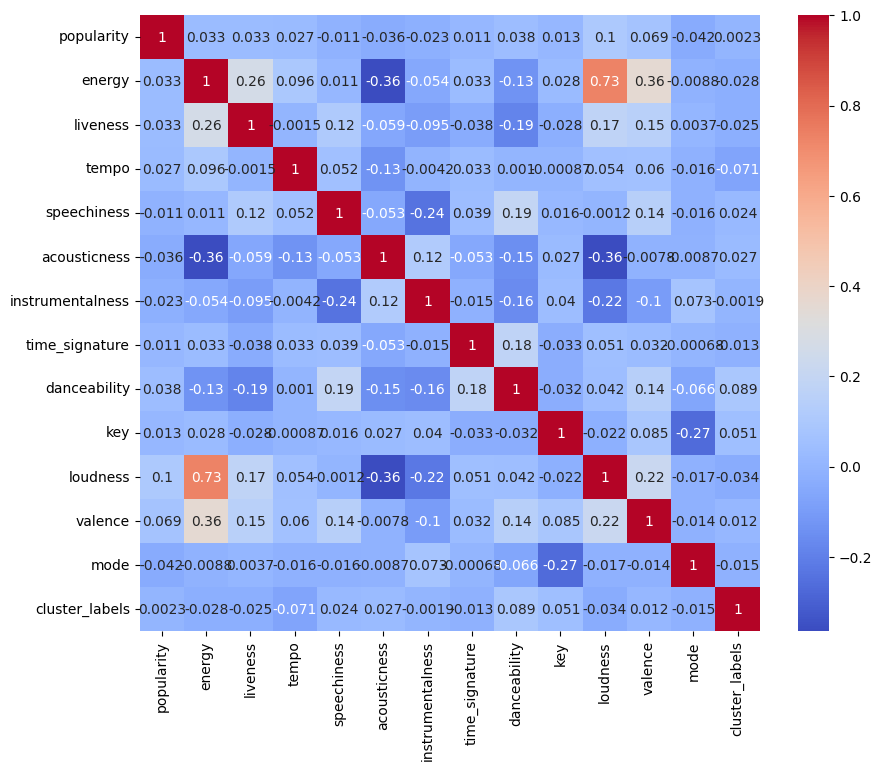

In [180]:
scaler = StandardScaler()
test_scaled = scaler.fit_transform(df_f)

test_df = pd.DataFrame(test_scaled, columns = df_f.columns)

corr_matrix = test_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

## Analyzing Feature Importance with RandomForestClassifier

After standardizing the data, I perform further analysis to understand each feature's impact on the dataset. First, I graph a simple correlation matrix to identify any clear multicollinearity or skewing. Surprisingly, it's not too bad. The only clear outlier is between 'energy' and 'loudness', which may indicate further issues. But before taking any measures, I'm going to check a few more indicators of the features' effects on the data.

Now, we have a RandomForestClassifier supervised learning method that runs numerous tests on independent variables and their predictions concerning the target variable. The aggregate of these tests then gives an idea as to what their overall importance will be in comparison to the other features. However, the very crux of my end goal here is based entirely in unsupervised learning, which definitely made this a very difficult journey. So, for the sake of being able to analyze the feature importance, I apply the very simplest of K-means clustering onto our scaled, but otherwise untouched data. This will then give us clusters which can be used as the target variable so we can see how each feature played into predicting this result.

In [181]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans



features = ['popularity', 'energy', 'liveness', 'tempo', 'speechiness',
            'acousticness', 'instrumentalness', 'time_signature', 'danceability',
            'key', 'loudness', 'valence', 'mode']

kmeanst = KMeans(n_clusters=15, random_state=42)

kmeanst.fit(test_df)

clusterstest = kmeanst.labels_


test_df['cluster_labels'] = clusterstest

X = test_df.drop('cluster_labels', axis=1)
y = test_df['cluster_labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(X_train, y_train)

importances = pd.DataFrame(list(zip(features, clf.feature_importances_)), columns=['Feature', 'Importance'])
print("\nFeature Importances:\n", importances)


Feature Importances:
              Feature  Importance
0         popularity    0.111938
1             energy    0.077952
2           liveness    0.101039
3              tempo    0.126994
4        speechiness    0.074720
5       acousticness    0.084543
6   instrumentalness    0.080836
7     time_signature    0.031801
8       danceability    0.047845
9                key    0.051287
10          loudness    0.076194
11           valence    0.069448
12              mode    0.065403


## Assessing Multicollinearity with Variance Inflation Factor (VIF)

As there's not a very messy deviation in our data, I would have ideally liked to deduce which features truly play a role in the prediction to focus on them during the later clustering. To further investigate multicollinearity, we employ **Variance Inflation Factor (VIF)** testing alongside the correlation matrix. _Multicollinearity_ is a phenomenon where two or more predictor variables in a multiple regression model have a strong correlation, causing issues in interpreting a feature's importance. Basically, it makes the data harder to read, and I don't want to deal with difficult data, so let's test for it.

VIF is calculated for each independent variable by regressing that variable against all other independent variables in the model. For a given predictor variable Xi, the VIF is calculated as follows:

```
VIFi = 1 / (1 - Ri^2)
```
Where Ri^2, or r-squared, is the coefficient of determination of the regression of Xi on the other independent variables. A VIF of 1 means there's no correlation, a VIF of 5 is a cause for concern, and a VIF of 10 is just unfortunate.

Fortunately, our VIF results are quite good. The highest VIF value is seen in the _loudness-energy_ correlation that we discovered earlier in the correlation matrix.

In [182]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
test_df.drop(columns=["cluster_labels"], inplace=True)
vif = test_df
vif_data = pd.DataFrame()
vif_data["feature"] = test_df.columns
vif_data["VIF"] = [variance_inflation_factor(test_df.values, i)
for i in range(len(vif.columns))]
print(vif_data)

             feature       VIF
0         popularity  1.023021
1             energy  2.903901
2           liveness  1.149133
3              tempo  1.029727
4        speechiness  1.133861
5       acousticness  1.291507
6   instrumentalness  1.186506
7     time_signature  1.037909
8       danceability  1.308180
9                key  1.098585
10          loudness  2.483196
11           valence  1.308944
12              mode  1.093684


## Feature Selection for Analysis

Now it's time to properly select our features. Based on our results obtained from correlation matrices and VIF tests, along with domain knowledge, I decide to omit and keep certain features for further analysis. Here's a list of the features I decide to exclude:

1. **Loudness**: Removed to reduce multicollinearity as it has a high correlation with energy. I believe energy to be a more important aspect of a song.
2. **Liveness**: This measures if a song was performed live, which I don't really care about.
3. **Popularity**: Not a significant factor for my analysis.
4. **Speechiness**: The degree to which a song is spoken seems like an unnecessary statistic to measure.
5. **Key, Mode, and Time Signature**: These categorical variables make scaling and interpreting specific data difficult, and I believe their essence is still hinted at in our remaining numerical data.

By removing these features, I'm left with a more manageable and meaningful set of features to explore and analyze further.


In [198]:
columns_to_remove=["liveness", "popularity", "loudness", "speechiness", "key", "mode", "time_signature"]
data = df_f.drop(columns_to_remove, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1750 entries, O Pana! to Strike (Holster)
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   energy            1750 non-null   float64
 1   tempo             1750 non-null   float64
 2   acousticness      1750 non-null   float64
 3   instrumentalness  1750 non-null   float64
 4   danceability      1750 non-null   float64
 5   valence           1750 non-null   float64
dtypes: float64(6)
memory usage: 95.7+ KB


## Analyzing Histograms and Kernel Density Plots

Below, we observe some beautiful histogram and kernel density plots of our unscaled data, which help to visualize the distribution of each feature. While some features appear to have a fairly normal distribution, others (such as instrumentalness) deviate significantly.

The rule of thumb for acceptable skewness is typically a value between -0.5 and 0.5. Some of our features fall outside this range and exhibit more extreme skewness, like instrumentalness.

### Insights from the Plots

- **Features with normal distribution**: These features might not need further transformation and can be directly used in analysis or modeling.
- **Features with high skewness**: For the skewed features, you might consider applying appropriate transformations (such as log, square root, or Box-Cox) to bring them closer to normality before proceeding with further analysis.

These visualizations help to identify the need for any further data preprocessing to ensure better performance in subsequent analysis or modeling.

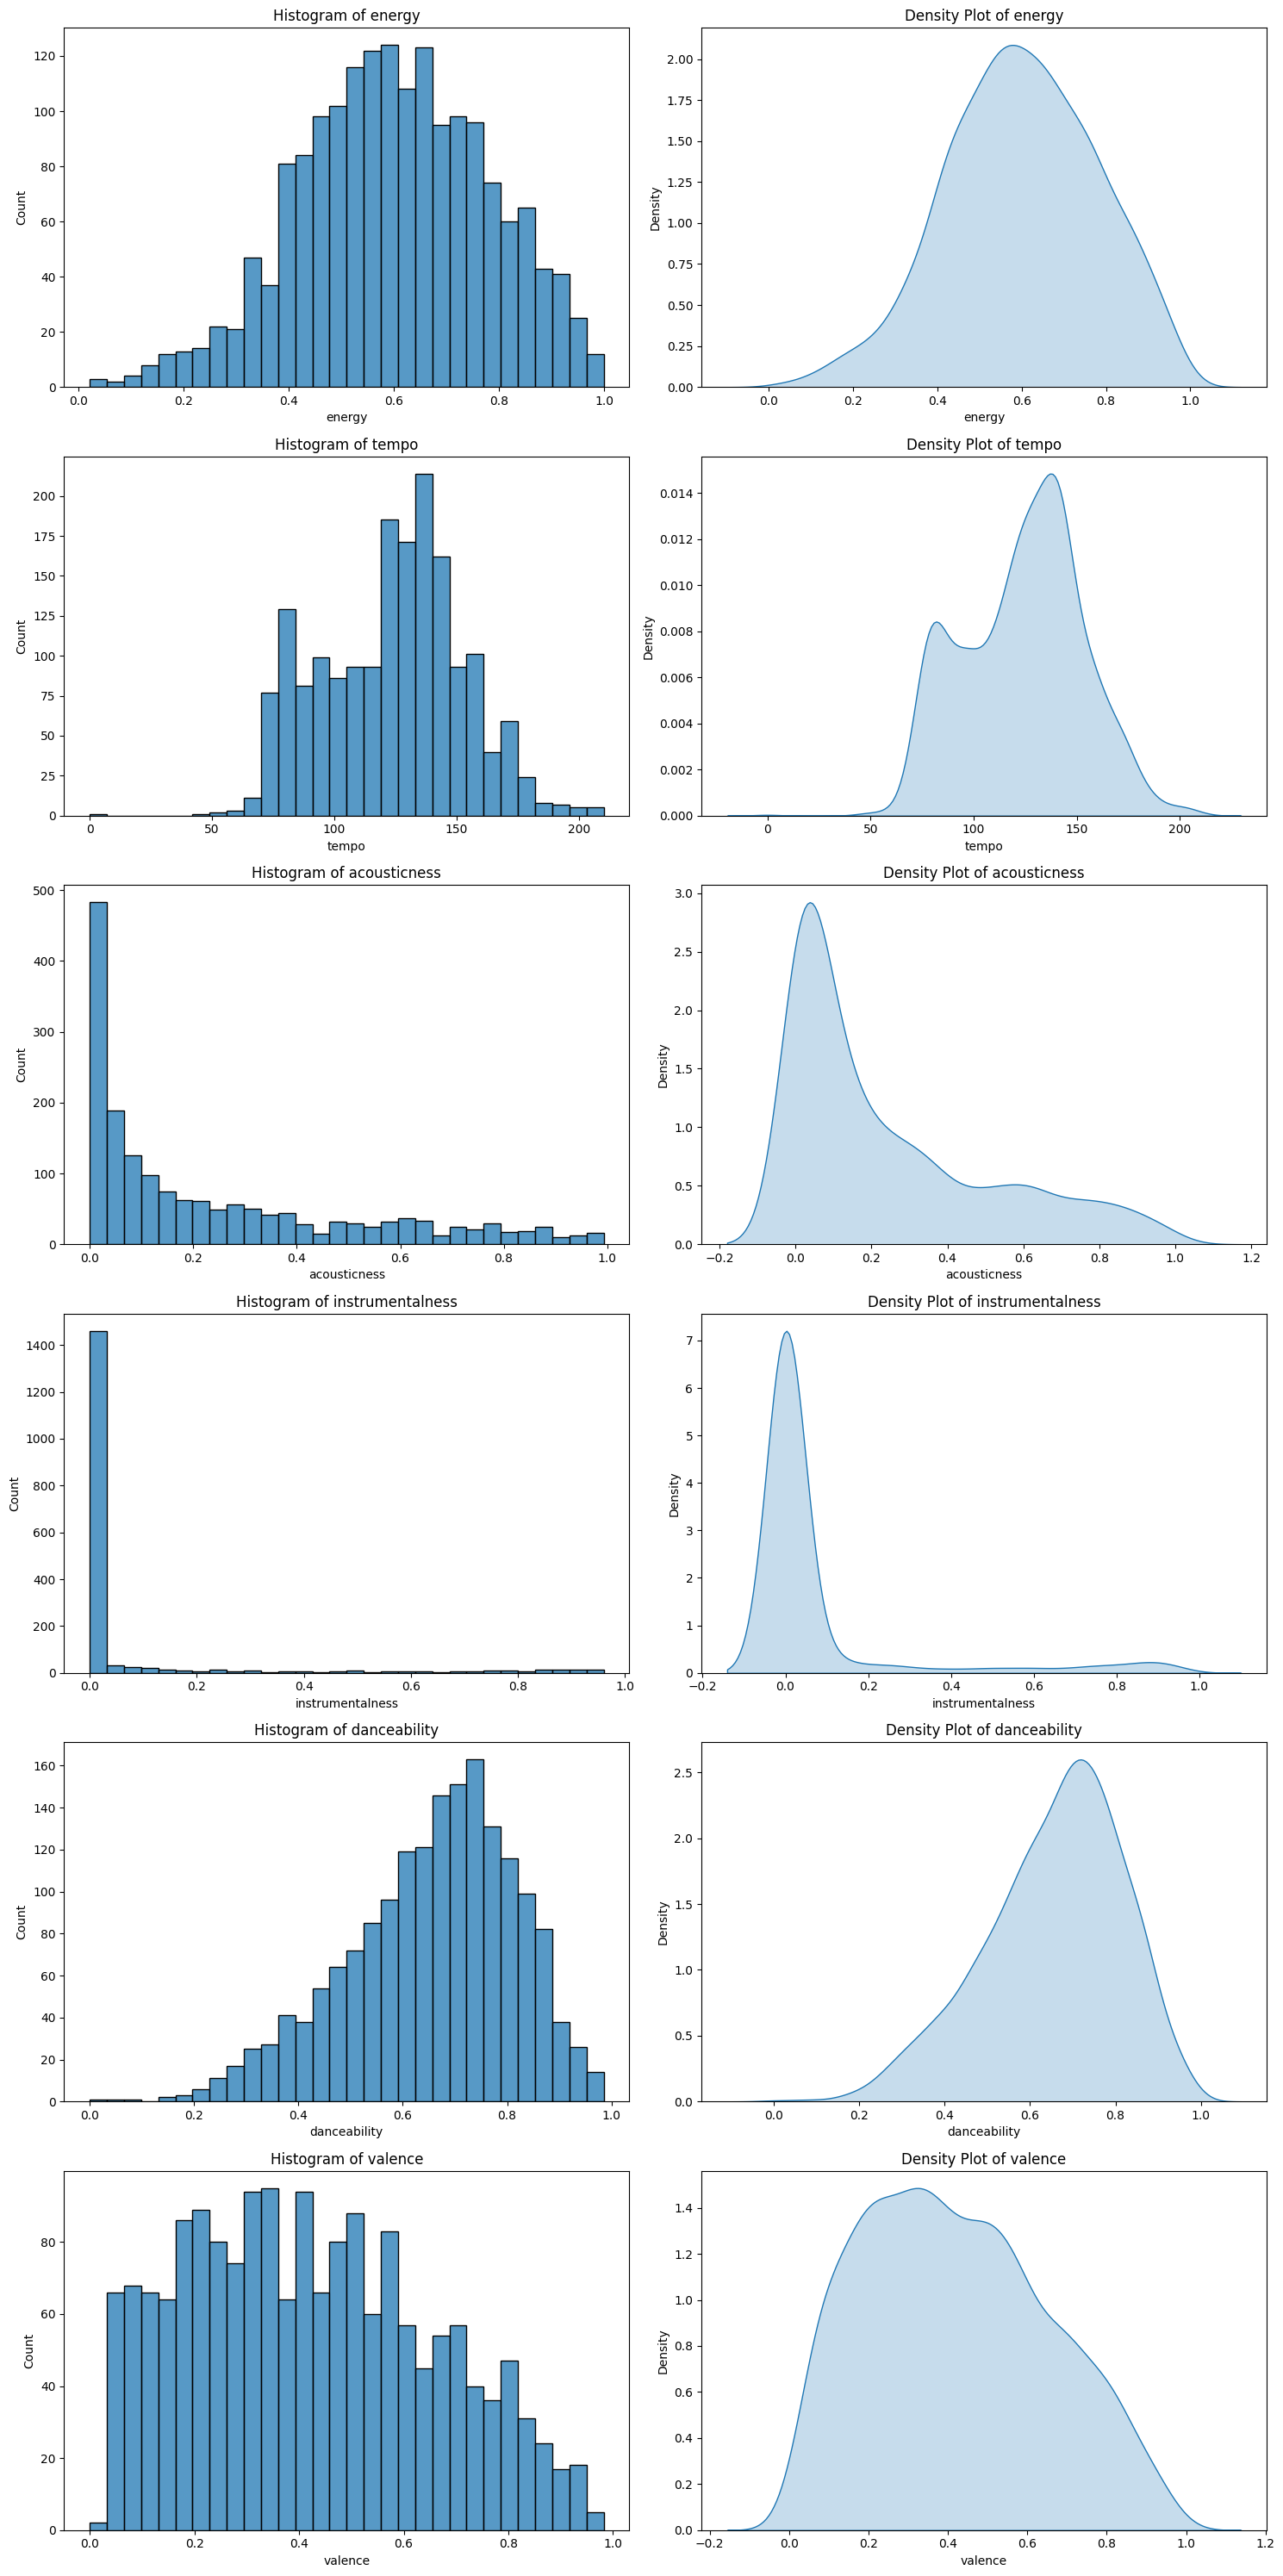

In [199]:
data = df_f.drop(columns_to_remove, axis=1)
num_features = data.select_dtypes(include=[np.number]).columns
figure, axes = plt.subplots(len(num_features), 2, figsize=(15, 5 * len(num_features)))

i = 0
for feature in num_features:
    sns.histplot(data[feature], kde=False, ax=axes[i][0], bins=30)
    axes[i][0].set_title(f'Histogram of {feature}')
    sns.kdeplot(data[feature], fill=True, ax=axes[i][1])
    axes[i][1].set_title(f'Density Plot of {feature}')
    i += 1

plt.tight_layout()
plt.show()

In [200]:
print("Skewness Values: ")
print(data.skew())

Skewness Values: 
energy             -0.189202
tempo              -0.079355
acousticness        1.116217
instrumentalness    3.041488
danceability       -0.569501
valence             0.291514
dtype: float64


## Tackling Skewness with Transformations

Looking at our lovely histogram and kernel density plots, I identify the right-skewed (longer tail on the right) and left-skewed (longer tail on the left) features. I want to apply different transformations to them to help create more symmetric distributions because, well, symmetry is beautiful.

### Transformations:

- **Right-skewed columns**: I apply a Box-Cox transformation. What's cool about Box-Cox is that it's like a bundle of power transformations that figures out the optimal power to apply to the data to make it prettier (that is, more symmetrical).
- **Left-skewed columns**: I use a simple square transformation—it's just squaring the data. By doing this, it's stretching the data closer to a more symmetrical distribution.

### Checking Out the Results

- **Square transformation**: It worked nicely! Both left-skewed values were pulled back into the realm of being reasonable in their skewing.
- **Box-Cox transformation**: Unfortunately, Box-Cox failed me for the right-skewed columns... So, I must try other statistical techniques to show them who's boss.

Applying these transformations helps make my features more symmetrical, which is essential because it'll improve the performance in the next steps of my analysis and modeling.

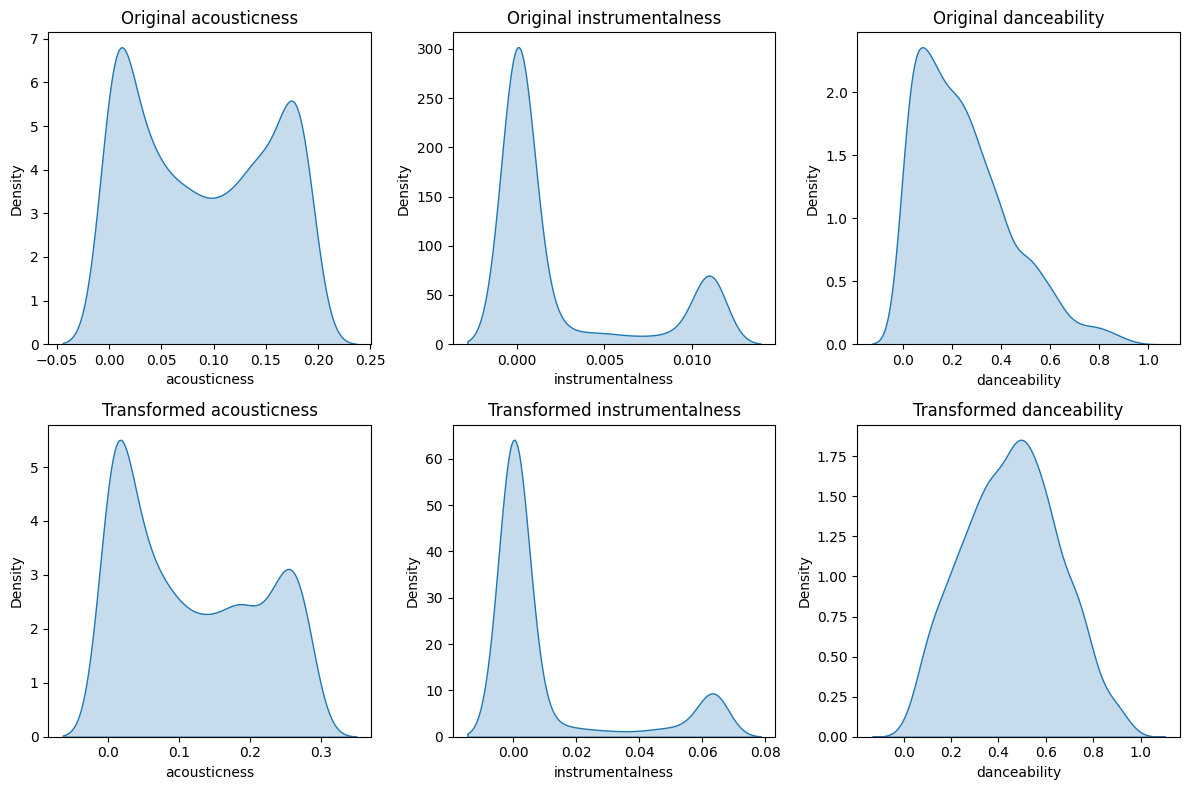

Skewness Values: 
energy             -0.189202
tempo              -0.079355
acousticness        0.311325
instrumentalness    1.856363
danceability        0.046399
valence             0.291514
dtype: float64


In [201]:
from scipy.stats import boxcox
data = df_f.drop(columns_to_remove, axis=1)



right_skewed_columns = ['acousticness', 'instrumentalness']
for col in right_skewed_columns:
    if data[col].nunique() > 1:
        data[col], _ = boxcox(data[col] + 1)

left_skewed_columns = ['danceability']
for col in left_skewed_columns:
    if data[col].nunique() > 1:
        data[col] = np.square(data[col])

columns_to_plot = right_skewed_columns + left_skewed_columns
n_cols = len(columns_to_plot)

fig, axes = plt.subplots(nrows=2, ncols=n_cols, figsize=(4 * n_cols, 8))

for i, col in enumerate(columns_to_plot):
    sns.kdeplot(data_original[col], ax=axes[0, i], fill=True)
    axes[0, i].set_title(f'Original {col}')
    sns.kdeplot(data[col], ax=axes[1, i], fill=True)
    axes[1, i].set_title(f'Transformed {col}')

plt.tight_layout()
plt.show()
print("Skewness Values: ")
print(data.skew())

## Trying Log Transformation and Binning on Instrumentalness Feature

Since the Box-Cox transformation didn't succeed, I explore two more transformations for the 'instrumentalness' feature: log transforming and binning.

### Log Transformation

- Specifically, I try the log(1 + x) transformation, which is often used to compress the range and bring values closer together, reducing the impact of very large values/outliers.
- As we can see, it didn't do very much to address the skewness.

### Binning

- Binning is a technique used to group continuous numerical data into discrete categories known as bins.
- In my code, custom bins and labels are defined for the 'instrumentalness' feature, and `pd.cut()` function is used to bin the feature using the specified ranges and labels.
- While this simplified the visual representation, it also confirmed what I already knew: the feature is still skewed.

From these attempts, we observe that both log transformation and binning didn't significantly improve the skewness of the 'instrumentalness' feature. It would be beneficial to explore additional techniques that might help in transforming this feature for better analysis and modeling.

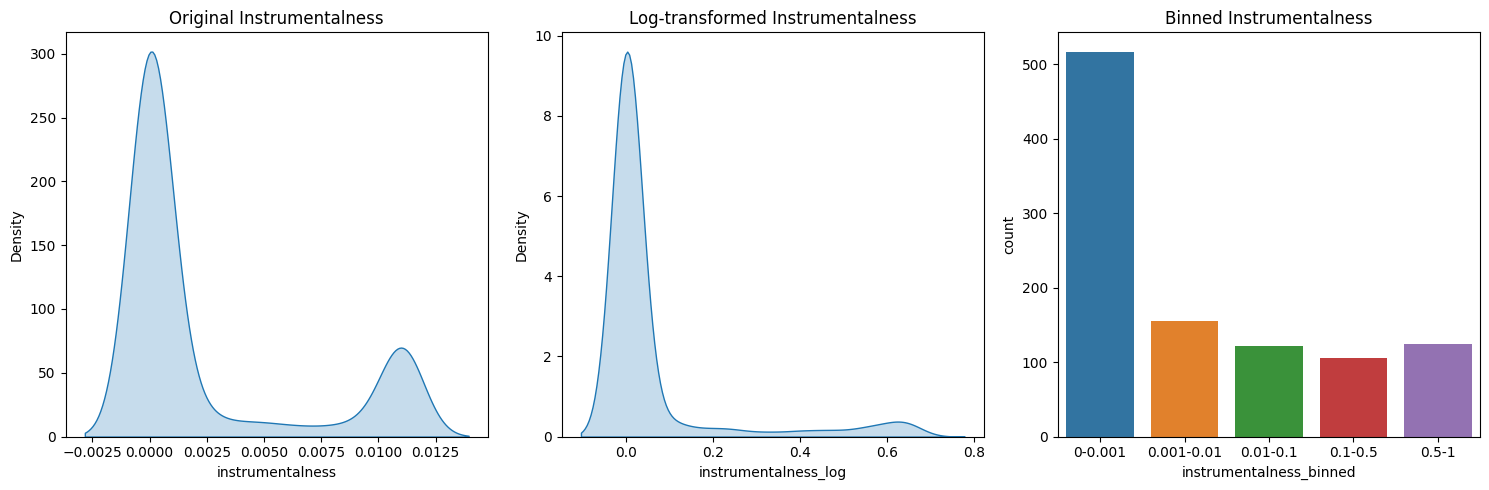

In [202]:
data = df_f.drop(columns_to_remove, axis=1)

data['instrumentalness_log'] = np.log1p(data['instrumentalness'])

bins = [0, 0.001, 0.01, 0.1, 0.5, 1]
labels = ['0-0.001', '0.001-0.01', '0.01-0.1', '0.1-0.5', '0.5-1']
data['instrumentalness_binned'] = pd.cut(data['instrumentalness'], bins=bins, labels=labels)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.kdeplot(data_original['instrumentalness'], ax=axes[0], fill=True)
axes[0].set_title('Original Instrumentalness')

sns.kdeplot(data['instrumentalness_log'], ax=axes[1], fill=True)
axes[1].set_title('Log-transformed Instrumentalness')

sns.countplot(data=data, x='instrumentalness_binned', ax=axes[2])
axes[2].set_title('Binned Instrumentalness')

plt.tight_layout()
plt.show()

## Applying Quantile Transformation

As a last-ditch effort to deal with the skewness in the 'instrumentalness' feature, I try a **quantile transformation**.

- A quantile transformation is a technique used to transform the distribution by mapping the feature's values to corresponding quantiles in a target distribution.
- Essentially, it calculates a cumulative production function (CPF) for 'instrumentalness' and maps the CPF to the associated target quantiles.

### Results of Quantile Transformation

- The end result is not perfect by any stretch of the word, but it seems to be within the acceptable range of symmetry.
- If needed, it can be further transformed down the line.

With this final attempt, I achieve a somewhat more symmetrical distribution for the 'instrumentalness' feature using quantile transformation. Although not ideal, it brings the feature closer to the desired level for better analysis and modeling.
I make a last ditch effort in the form of a quantile transformation, a technique used to transform the distribution by mapping the feature's values to corresponding quantiles in a target distribution. This essentially calculates a cumulative production function (CPF) for instrumentalness and then maps the CPF to the associated target quantiles. Now, the end result is not perfect by any stretch of the word, but it seems to be within the acceptable range of symmetry and it can be later transformed down the line. 

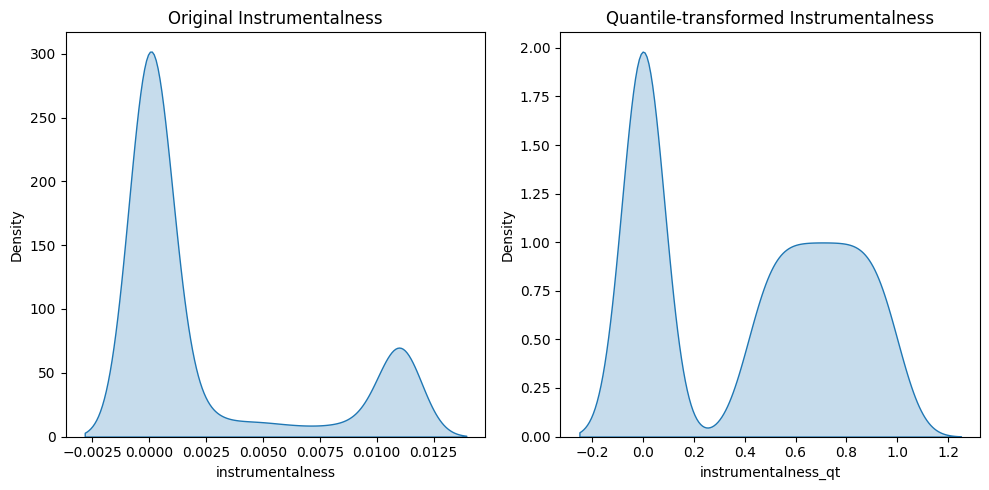

In [203]:
from sklearn.preprocessing import QuantileTransformer
data = df_f.drop(columns_to_remove, axis=1)

qt = QuantileTransformer(n_quantiles=1000, output_distribution='uniform', random_state=42)
data['instrumentalness_qt'] = qt.fit_transform(data[['instrumentalness']])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.kdeplot(data_original['instrumentalness'], ax=axes[0], shade=True)
axes[0].set_title('Original Instrumentalness')

sns.kdeplot(data['instrumentalness_qt'], ax=axes[1], shade=True)
axes[1].set_title('Quantile-transformed Instrumentalness')

plt.tight_layout()
plt.show()

### Results of Quantile Transformation

As we can see, it actually turned into our best feature in the dataset by strictly looking at our final data set's skewing values.

Moving forward, we then scale our data, a step that was unnecessary in terms of analyzing individual distributions. We will first selectively use a `MinMax Scaler` which looks at a feature's maximum values and minimum values separately and places it into a scale from 0 to 1. 

In [204]:
data = df_f.drop(columns_to_remove, axis=1)
qt = QuantileTransformer(n_quantiles=1000, output_distribution='uniform', random_state=42)
data['instrumentalness'] = qt.fit_transform(data[['instrumentalness']])
right_skewed_columns = ['acousticness']
for col in right_skewed_columns:
    if data[col].nunique() > 1:
        data[col], _ = boxcox(data[col] + 1)

left_skewed_columns = ['danceability']
for col in left_skewed_columns:
    if data[col].nunique() > 1:
        data[col] = np.square(data[col])
data.skew()

energy             -0.189202
tempo              -0.079355
acousticness        0.311325
instrumentalness    0.001502
danceability        0.046399
valence             0.291514
dtype: float64

In [216]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from scipy.stats import boxcox

df = pd.read_csv("descriptors.csv")
df.fillna("", inplace=True)

scaler = MinMaxScaler()

df['danceability_normalized'] = scaler.fit_transform(df[['danceability']])
df['energy_normalized'] = scaler.fit_transform(df[['energy']])
df['acousticness_normalized'] = scaler.fit_transform(df[['acousticness']])
df['instrumentalness_normalized'] = scaler.fit_transform(df[['instrumentalness']])
df['valence_normalized'] = scaler.fit_transform(df[['valence']])
df['tempo_normalized'] = scaler.fit_transform(df[['tempo']])


## 'Number to Text' Translator for Standardized Features

This code is so long and horrendous because I was truthfully going to use it in a much different manner when I originally began, but that idea got tossed quick. However, the code did not get tossed quick and I was able to easily repurpose it into an effective 'number to text' translator. For each one of our features, it looks at the now 0-1 standardized scale and classifies quantiles within this range that have a textual description attached to them. Therefore, based on a feature's value for a given track/song it can be pulled out of the numeric world and into the textual world like the rest of our genres and lyrical data.

In [217]:
import random
def assign_danceability(value):
    not_suitable = [
        'Not suitable for dancing', 
        'Terrible for dancing', 
        'No dance vibes', 
        'Not engaging at all', 
        'Barely entertaining', 
        'Lacks energy and rhythm', 
        'Not recommended for fun activities'
    ]
    slightly_suitable = [
        'Slightly suitable for dancing', 
        'A hint of danceability', 
        'Could maybe dance to this', 
        'Mildly engaging', 
        'Somewhat entertaining', 
        'A touch of rhythm', 
        'Not bad for casual fun'
    ]
    suitable = [
        'Suitable for dancing', 
        'Danceable', 
        'Move to the groove', 
        'Engaging and entertaining', 
        'Good for a variety of activities', 
        'Catchy rhythm and beat', 
        'Fun for parties and gatherings'
    ]
    highly_suitable = [
        'Highly suitable for dancing', 
        'Perfect for dancing', 
        'Dance floor magnet', 
        'Extremely engaging', 
        'Highly entertaining', 
        'Ideal for various activities', 
        'A must-have for any party playlist'
    ]
    cant_stop_moving = [
        'Dance party essential', 
        "Can't stop moving", 
        'Irresistible dance moves', 
        'Incredibly captivating', 
        'Unbelievable entertainment', 
        'Perfect for any energetic activity', 
        'Impossible to sit still'
    ]
    if value <= 0.2:
        return not_suitable[index]
    elif value <= 0.4:
        return slightly_suitable[index]
    elif value <= 0.6:
        return suitable[index]
    elif value <= 0.8:
        return highly_suitable[index]
    else:
        return cant_stop_moving[index]


def assign_energy(value):
    sloth_like = [
        'Sluggish energy','Sloth-like', 'Laid-back energy', 'Super relaxed', 'Lazy vibes', 'Couch potato mode',
         'Doze-inducing', 'Mellow to the core', 'Zero rush'
    ]

    chill_vibes = [
        'Calm energy', 'Chill vibes', 'Easygoing energy', 'Cool and calm', 'Breezy presence', 'Stress-free spirit',
        'Unruffled demeanor', 'Languid essence', 'Serene and tranquil'
    ]

    average_energy = [
        'Average energy', 'Steadily paced', 'Middle-of-the-road energy', 'Neither high nor low energy', 'Neutral tempo',
        'Balanced liveliness', 'Standard vitality', 'Routine dynamism', 'Moderate pep'
    ]

    energetic = [
        'Energetic', 'Excitedly paced', 'Full of life', 'Bouncing with energy', 'Active and animated', 'Vibrant spirit',
        'Sprightly enthusiasm', 'Brisk and lively', 'Fired up', 'Peppy and zippy'
    ]

    vitality_overload = [
        'Explosively energetic','Vitality overload', 'Through the roof energy', 'Turbocharged zest',
        'Supersonic liveliness', 'Hyperactive buzz', 'Intense vigor', 'Frenetic enthusiasm', 'Unstoppable force'
    ]
    if value <= 0.2:
        return sloth_like[index]
    elif value <= 0.4:
        return chill_vibes[index]
    elif value <= 0.6:
        return average_energy[index]
    elif value <= 0.8:
        return energetic[index]
    else:
        return vitality_overload[index]




def assign_acousticness(value):
    high_tech = ['Technologically enhanced beyond acoustic','High-tech', 'Synthetic sounds', 'Electronic vibes', 'Futuristic audio', 'Digitally-enhanced', 'Cutting-edge sonics', 'Modernized melodies', 'Innovative audio experiences', 'Robotic rhythms', 'Sci-fi soundscapes']

    electro_acoustic = ['Deeper fusion of acoustic and digital', 'Electro-acoustic', 'Hybrid sounds', 'Mix of natural and electronic', 'Synergy of organic and synthetic', 'Crossover tones', 'Amalgamated audio', 'Blended soundscapes', 'Melded melodies', 'Technorganic tunes']

    balanced = ['Combination of acoustic and electronic', 'Balanced', 'Well-rounded sound', 'Equilibrium audio', 'Harmonious blend', 'Even mix of sound sources', 'In-sync audio', 'Stable soundscapes', 'Yin-yang of audio', 'Auditory harmony']

    acoustic = ['Pure Acoustic', 'Natural sound', 'Unprocessed and organic', 'Authentic audio', 'Raw resonance', 'Original and unmodified', 'Pure and untouched', 'Straight-from-the-source', 'True-to-life tones', 'Untainted tunes']

    unplugged = ['Bare-bones acoustic', 'Unplugged', 'Stripped-down and raw','Unadorned acoustics', 'Simple and honest sound', 'Essence of the music', 'Back-to-basics', 'Intimate and close-up', 'Straight to the heart sounds']

    if value <= 0.2:
        return high_tech[index]
    elif value <= 0.4:
        return electro_acoustic[index]
    elif value <= 0.6:
        return balanced[index]
    elif value <= 0.8:
        return acoustic[index]
    else:
        return unplugged[index]


def assign_instrumentalness(value):
    vocal_centric = ['Vocal-centric instrumentalness', 'Lyric-focused', 'All about the voice', 'Voice-driven', 'Singing takes the spotlight', 'Primarily vocal', 'Centered on vocals', 'Lyrics steal the show']

    vocal_instrumental_blend = ['Vocal-instrumental blend', 'Nice mix of vocals and instruments', 'Equal focus on voice and instruments', 'Harmonious vocal-instrumental balance', 'Perfect fusion of voice and instruments', 'Vocals and instruments in sync', 'Even emphasis on both vocals and instruments', 'Neck and neck with voice and instruments']

    instrumental_leaning = ['Instrumental-leaning', 'More instrumental than vocal', 'Instruments take center stage', 'Instruments lead the charge', 'Vocals play supporting role', 'Emphasis on the instrumentals', 'Instrument-heavy with a dash of vocals', 'Instruments in the limelight']

    instrumental_dominant = ['Instrumental dominant', 'Mostly instrumental', 'Vocals take a backseat', 'Instruments reign supreme', 'Vocals sparingly used', 'Majority of focus on instrumentals', 'Mainly about the instruments', 'Barely any vocals present']

    completely_instrumental = ['Completely instrumental', 'No vocals', 'Purely instrumental sounds', 'Devoid of vocals', 'Vocals-free', 'All-instrumental performance', 'Solely about instrumentals', 'Without a hint of vocalization']

    if value <= 0.2:
        return vocal_centric[index]
    elif value <= 0.4:
        return vocal_instrumental_blend[index]
    elif value <= 0.6:
        return instrumental_leaning[index]
    elif value <= 0.8:
        return instrumental_dominant[index]
    else:
        return completely_instrumental[index]

    
    if value <= 0.2:
        return heartbroken[index]
    elif value <= 0.4:
        return blue[index]
    elif value <= 0.6:
        return neutral[index]
    elif value <= 0.8:
        return joyful[index]
    else:
        return ecstatic[index]


def assign_tempo(value):
    molasses_slow = ['Slow tempo', 'Molasses slow', 'Crawling tempo', 'Glacial progress', 'Snail-like pace', 'Dawdling gait', 'Languid motion']
    slow = ['Relaxed', 'Unhurried', 'Relaxed tempo', 'Easygoing stride', 'Measured pace', 'Unruffled cadence', 'Laid-back rhythm']
    moderate = ['Medium tempo', 'Steady pace', 'Medium tempo', 'Balanced tempo', 'Composed gait', 'Even pace', 'Temperate rhythm']
    fast = ['Fast tempo', 'Upbeat', 'Quick tempo', 'Brisk pace', 'Swift stride', 'Nimble rhythm', 'Energetic motion']
    lightning_fast = ['Rapid tempo', 'Rapid-fire pace', 'Breakneck speed', 'Blistering quickness', 'Frenetic haste', 'Meteoric velocity', 'Turbulent acceleration']

    if value <= 0.2:
        return molasses_slow[index]
    elif value <= 0.4:
        return slow[index]
    elif value <= 0.6:
        return moderate[index]
    elif value <= 0.8:
        return fast[index]
    else:
        return lightning_fast[index]
    

def assign_valence(value):
    worse = ["Devastated"] 
    bad = ["Dismayed"]
    neutral = ["Neutral emotions"]
    good = ["Joyful emotions"]
    great =["Ecstatic"]
    
    if value <= 0.2:
        return worse[index]
    elif value <= 0.4:
        return bad[index]
    elif value <= 0.6:
        return neutral[index]
    elif value <= 0.8:
        return good[index]
    else:
        return great[index]    
    
    
index=0

df['danceability_normalized'] = df['danceability_normalized'].apply(assign_danceability)
df['energy_normalized'] = df['energy_normalized'].apply(assign_energy)
df['acousticness_normalized'] = df['acousticness_normalized'].apply(assign_acousticness)
df['instrumentalness_normalized'] = df['instrumentalness_normalized'].apply(assign_instrumentalness)
df['valence_normalized'] = df['valence_normalized'].apply(assign_valence)
df['tempo_normalized'] = df['tempo_normalized'].apply(assign_tempo)

## Converting Features to Text Embeddings

I set the `index=0`, which means that only the first item from all those lists of descriptors will be chosen, based on where a feature lies on the scale. This is because these features will be used in textual embedding, which thrives on consistency.

### Embedding Process

Below, I use OpenAI's `text-embedding-ada-002` model for the embedding processing. This model outputs a list of 1,536 floating points that lie inside a vector. Each of these points represents an arbitrary aspect/relationship this data holds in the context of its own content and the content of other text embeddings.

### Importance of Vector Length

The length of the vector is crucial, which is why I had to translate our numeric data into textual data before turning it back into numeric data. 

- **Embeddings are not numerical**: Embeddings are not numerical in a typical sense; they don't have a true scale but are rather a gross quantitative synecdoche of a text's meaning. It would be challenging to compare them earnestly with truly numeric data that finds its meaning in its numeric value.

- **Dimensionality and weight**: It's complex to accurately and proportionately calculate dimensionality and proper weight for comparing a (1536, 1) dimension feature with a 2D figure. I learned this frustratingly through trial and error.

By converting features to text embeddings, we can better analyze and compare textual content in the context of our dataset for more meaningful insights.

In [61]:
import concurrent.futures
import time
import pandas as pd
import openai
import tenacity
from typing import List, Dict, Tuple
from tqdm import tqdm

EMBEDDING_MODEL = "text-embedding-ada-002"


@tenacity.retry(reraise=True, stop=tenacity.stop_after_attempt(3), wait=tenacity.wait_fixed(5) + tenacity.wait_exponential(multiplier=2))
def get_embedding(text: str, model: str = EMBEDDING_MODEL, vector_length=1536):
    if not text:
        return [0] * vector_length
    
    time.sleep(0.1)  
    result = openai.Embedding.create(
        model=model,
        input=text,
        output_format="list",
        vector_length=vector_length
    )
    return result["data"][0]["embedding"]

def get_embeddings_concurrently(texts: List[str], batch_size: int = 50) -> List[List[float]]:
    embeddings = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        batches = [texts[i:i+batch_size] for i in range(0, len(texts), batch_size)]
        for batch in tqdm(batches, total=len(batches)):
            future_to_embedding = {executor.submit(get_embedding, text): text for text in batch}
            for future in concurrent.futures.as_completed(future_to_embedding):
                try:
                    embedding = future.result()
                    embeddings.append(embedding)
                except Exception as e:
                    print(f"Failed to obtain embedding: {e}")
                    embeddings.append(None)
    return embeddings


df_embed = df[["title", "descriptors", "genres", "danceability_normalized", "energy_normalized", "acousticness_normalized", "instrumentalness_normalized", "valence_normalized", "tempo_normalized",]]
df_embed["numerical_features"] = df_embed[["danceability_normalized", "energy_normalized", "acousticness_normalized", "instrumentalness_normalized", "valence_normalized", "tempo_normalized"]].apply(lambda row: ' '.join(row.map(str)), axis=1)

descriptors_embeddings = get_embeddings_concurrently(df_embed["descriptors"].tolist())
genres_embeddings = get_embeddings_concurrently(df_embed["genres"].tolist())
numerical_features_embeddings = get_embeddings_concurrently(df_embed["numerical_features"].tolist())

df_embeddings = pd.DataFrame({
    "title": df["title"],
    "descriptors_embedding": descriptors_embeddings,
    "genres_embedding": genres_embeddings,
    "numerical_features_embedding": numerical_features_embeddings
})

/var/folders/y_/d0wbwn_s1tlbh09zvpsn9bp40000gn/T/ipykernel_61853/360115022.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_embed["numerical_features"] = df_embed[["danceability_normalized", "energy_normalized", "acousticness_normalized", "instrumentalness_normalized", "valence_normalized", "tempo_normalized"]].apply(lambda row: ' '.join(row.map(str)), axis=1)
100%|███████████████████████████████████████████| 35/35 [01:34<00:00,  2.71s/it]


## Dividing Features into Three Embedding Sets

Thus, instead of having 6 audio features and one set of embeddings representing the lyrics and genres, I've divided it into 3. 

One of the combined numerical features, which retains an individual meaning due to the consistency of the textual descriptors applied to them above. 

The genres are another set of embeddings, however this is where another issue lies for me -- not all the songs had genres, and not all the songs had lyrics. To counteract this, I 'pad' the data with a 1536 list of 0s in spots where it's empty. The 0s are treated by later algorithms as neutral in a sense, and since I am using audio features as well, which exist for all the songs, it means that these song's do not need to be omitted at all from the final product. 

Lastly, I embed not the song's actual lyrics, but the descriptors we gathered earlier using `GPT-3.5-turbo`. In using a pattern keywords from an AI that was trained on a specific set of instructions I provided in example messages means that these descriptors are also somewhat uniform and similar in their content, and far far less noisy and difficult than simply embedding all of the lyrics. 

### Embedding Set Statistical Testing
Since these were embedded separately, it's good form to check for differentials in the scaling. Luckily, the means and standard deviations are extremely similar and pose no issue to the data.


In [62]:
import numpy as np

descriptors_mean = np.mean(np.mean(np.vstack(df_embeddings["descriptors_embedding"]), axis=0))
descriptors_std = np.mean(np.std(np.vstack(df_embeddings["descriptors_embedding"]), axis=0))

genres_mean = np.mean(np.mean(np.vstack(df_embeddings["genres_embedding"]), axis=0))
genres_std = np.mean(np.std(np.vstack(df_embeddings["genres_embedding"]), axis=0))

numerical_features_mean = np.mean(np.mean(np.vstack(df_embeddings["numerical_features_embedding"]), axis=0))
numerical_features_std = np.mean(np.std(np.vstack(df_embeddings["numerical_features_embedding"]), axis=0))

print("Descriptors mean and standard deviation:", descriptors_mean, descriptors_std)
print("Genres mean and standard deviation:", genres_mean, genres_std)
print("Numerical features mean and standard deviation:", numerical_features_mean, numerical_features_std)


Descriptors mean and standard deviation: -0.0006624432726102312 0.009985874238851751
Genres mean and standard deviation: -0.000655091559020203 0.010512090589250095
Numerical features mean and standard deviation: -0.0007223709017817755 0.006622184106810654


## Comparing Embedding Sets with K-means Clustering and Silhouette Score

Now, we want to evaluate the combined embeddings and how they fare in terms of their individual clustering's silhouette score. To do this, we perform basic K-means on our StandardScaled data (despite having no true variance issues, standardizing doesn't affect the efficacy of the embeddings).

### Silhouette Score

A silhouette score is calculated through the following formula:

```
Silhouette Score = (bi - ai) / max(ai, bi)
```

- `ai` is the average distance between data point `i` and all other data points within its cluster.
- `bi` is the average distance between data point `i` and all data points in the closest nearest cluster that `i` is not a part of.

The overall silhouette score is calculated by taking the average of the silhouette scores for all data points `i` in the dataset.

A score closer to 1 means that the data is cohesive within its own cluster and poorly matched to the clusters around it. We aim for a score closer to 1.

### Initial Scores and Insights

Our initial scores are not great, but that's to be expected without any dimensionality reduction or hyperparameter testing. For now, these scores merely show us that the genres embedding does a better job of creating clusters than that of the descriptors or the numerical features.


In [66]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from umap.umap_ import UMAP
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
import matplotlib.pyplot as plt

scaler = StandardScaler()
descriptors_scaled = scaler.fit_transform(df_embeddings["descriptors_embedding"].tolist())
genres_scaled = scaler.fit_transform(df_embeddings["genres_embedding"].tolist())
numerical_features_scaled = scaler.fit_transform(df_embeddings["numerical_features_embedding"].tolist())

kmeans = KMeans(n_clusters=20, random_state=42)
descriptors_clusters = kmeans.fit_predict(descriptors_scaled)
genres_clusters = kmeans.fit_predict(genres_scaled)
numerical_features_clusters = kmeans.fit_predict(numerical_features_scaled)

descriptors_silhouette = silhouette_score(descriptors_scaled, descriptors_clusters)
genres_silhouette = silhouette_score(genres_scaled, genres_clusters)
numerical_features_silhouette = silhouette_score(numerical_features_scaled, numerical_features_clusters)

print(f"Descriptors silhouette score: {descriptors_silhouette}")
print(f"Genres silhouette score: {genres_silhouette}")
print(f"Numerical features silhouette score: {numerical_features_silhouette}")


/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Descriptors silhouette score: 0.1068023386365533
Genres silhouette score: 0.26548196731323515
Numerical features silhouette score: 0.1301613527629044


## Combining Embeddings with Custom Weights

Based on the initial analysis, I decide to group the songs by genre as it seems more effective in properly dividing them up for my specific use case of creating smaller playlists. To build on the genre embedding's initial strength, I'm going to weigh it at 55%. Then, I account for the songs that may not have any genre information, and set the weight for numerical features to 30% and lyrical descriptors to 15%. Balancing these weights is a delicate process, as each one contributes significantly to the final product, even if they seem mathematically dwarfed by others.

### Steps to combine the embeddings with custom weights:

1. **Multiply each set of embeddings by their assigned weight**: Genres (55%), numerical features (30%), and lyrical descriptors (15%).
2. **Combine the weighted embeddings into a single embedding**: Sum the weighted embeddings to obtain a combined embedding that reflects the custom weights.

By applying these custom weights and combining the embeddings, I create a new embedding that leverages the strengths of genre information while still incorporating numerical features and lyrical descriptors.

In [68]:
descriptors_weight = .15
genres_weight = .55
numerical_features_weight = .3

def combine_and_weigh_embeddings(row):
    descriptors_embedding = np.array(row["descriptors_embedding"])
    genres_embedding = np.array(row["genres_embedding"])
    numerical_features_embedding = np.array(row["numerical_features_embedding"])
    
    combined_embedding = (
        descriptors_weight * descriptors_embedding +
        genres_weight * genres_embedding +
        numerical_features_weight * numerical_features_embedding
    )
    
    return combined_embedding.tolist()

df_embeddings["combined_embedding"] = df_embeddings.apply(combine_and_weigh_embeddings, axis=1)

## Testing Clustering Methods and Dimensionality Reduction Techniques

Now, we test the clustering. We use StandardScaler throughout and this is not for any arbitrary reason. Rather, I have a notebook worths of grueling graphical testing that almost stomped my soul away, but I deduced that `StandardScaler` is the optimal feature scaling method.

### Clustering Method: K-means

In addition, to make this overall process more difficult for myself, I purposefully strived for a large amount of playlists (15 < n < 25) due to the magnitude of my existing playlist. K-means would've been brilliant off the bat without question if I only wanted to do 3 clusters. Nevertheless, we must now go to testing.
 
The first clustering method we will be using is the aforementioned K-means. The K-means clustering is the most simplistic and applicable unsupervised machine learning algorithm that works by iteratively assigning data points to the cluster with the nearest centroid (the center of the cluster) until convergence, or a maximum number of specified iterations is reached. The ultimate goal is to minimize the sum of squared distances (inertia) between each data point and its centroid.

### Dimensionality Reduction Techniques

Since vector embeddings have high dimensions, which can both benefit semantic symbolism and challenge data manipulation, it's necessary to evaluate different dimensionality reduction techniques.

There are five graphs presented above, each representing a different approach to dimensionality reduction techniques, for which the optimal method must be selected.

By testing various clustering methods and dimensionality reduction techniques, we can identify the most effective combination to create meaningful and well-separated playlists from our embedding data.

#### Techniques:

1. **Variance Threshold:** This technique removes any features with low variance, under the assumption that low-variance features contain less information and probably wouldn't contribute in a beneficial way to the model. In terms of clustering, you want a higher variance in order to discern more local and global patterns that exist between data, thus I set the limit to around 80% -- where any lower means a feature is dropped. This measure of dimensionality reduction is a fossil from when I was attempting to cluster using the numerical features uncombined and also attempting expanded horizontal embedding features in trials. Thus, it's irrelevant and I don't think changes at all throughout the tests.

3. **Removing High Correlation Features (Low Correlated Features):** Here we remove one feature from each pair of any highly correlated features in the dataset. Highly correlated features can lead to multicollinearity issues and reduce the model's interpretability. This code also just stuck around from tests I did way back before any meaningful correlation testing on the numerical features like seen above, so it really means nothing and is just here. Now, to the 3 meaningful ones.

4. **PCA (Principal Component Analysis):** While we just saw that we had a technique that strived to reduce low variance, PCA aims to maximize high variance if that makes sense. Essentially, it attempts to reduce the maximum possible number of features in the dataset while still preserving that maximum variance. It identifies 'principal components' that capture the variance in the data, and projects the data onto these components (which exist as orthoganal axes on the flattened 2d graph). Fun fact, I also just learned that 'axes' is the correct plural for 'axis.' Wild. 

5. **t-SNE (t-Distributed Stochastic Neighbor Embedding):** This one is interesting because it's not really a proper way in which one would usually execute dimensionality reduction as it's moreso used as a non-linear technique in order to strictly visualize high-dimensional data by reducing it to 2-3 dimensions. It works by maintaining local and global structure in the data by minimizing the difference between joint probabilities in high-dimensional space and the low-dimensional space. That sounds like utter nonsense and I still think it is, but a joint probability captures the likelihood that any specified events occur simultaneously. Thus, t-SNE attempts to measure the joint-probability, or the similarity, between a pair of data points in a high dimensional space like our embeddings, and in a low dimensional space like is shown graphically. It then attempts to reproduce the high dimensional (global) layout in the smaller dimensional (local) space. This helps in visualizing data, and also in feature selection which is why I've kept it here throughout these tests.

6. **UMAP (Uniform Manifold Approximation and Projection):** UMAP is a non-linear technique, similar in many sorts to t-SNE, but with faster execution and its form being more scalable. In a very similar fashion, UMAP attempts to maintain both local and global structures in the data while mapping it to a lower-dimensional space. However, UMAP aims much much more to preserve the global strucure of data, which is sometimes not the most visually appealing form to remain in (as you can see). Thus, it holds patterns at far larger scales at the cost of being visually analyzed at times. 

/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


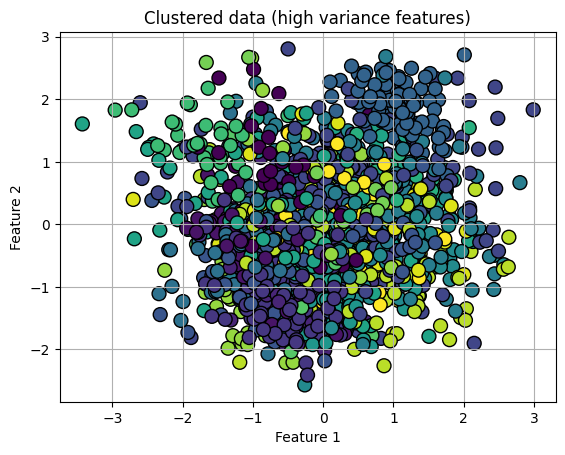

/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


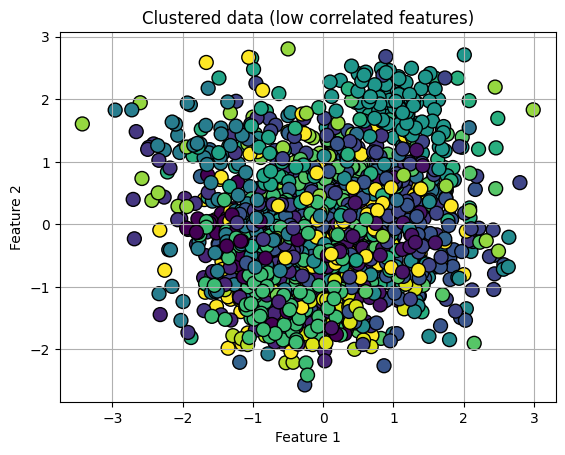

/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


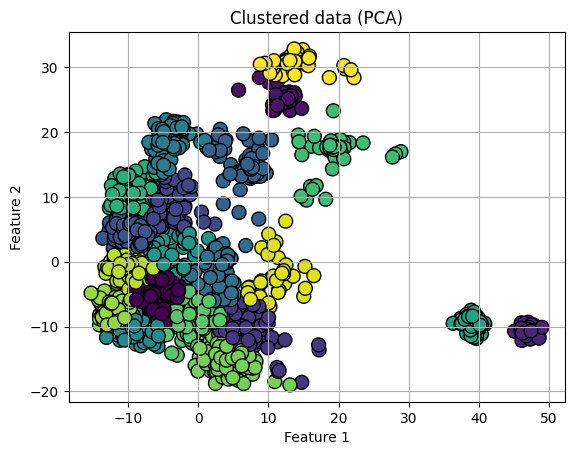

/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


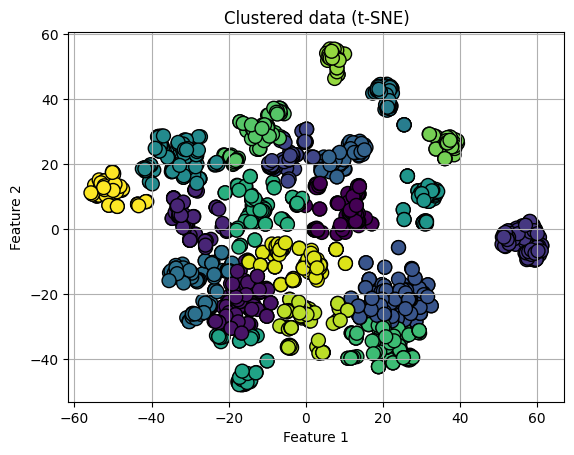

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


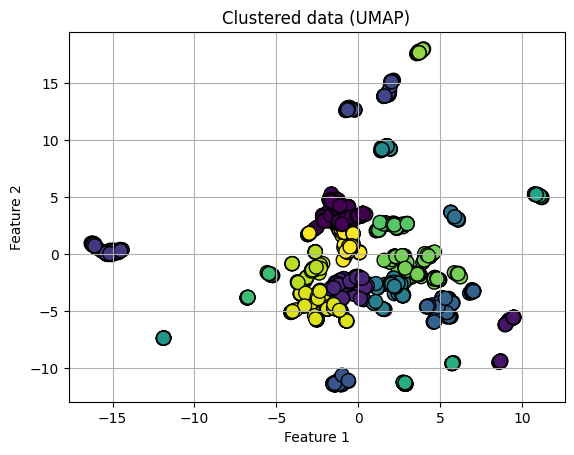

In [69]:


def plot_clustering(X, clusters, title):
    plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', edgecolor='k', s=100)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.grid()
    plt.show()

combined_embeddings_list = [embedding for embedding in df_embeddings["combined_embedding"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined_embeddings_list)

selector = VarianceThreshold(threshold=(0.8 * (1 - 0.8)))  
X_high_variance = selector.fit_transform(X_scaled)
selected_features = selector.get_support()

kmeans = KMeans(n_clusters=20, random_state=42)
clusters_high_variance = kmeans.fit_predict(X_high_variance)
plot_clustering(X_high_variance, clusters_high_variance, 'Clustered data (high variance features)')

correlation_matrix = np.abs(np.corrcoef(X_scaled, rowvar=False))
np.fill_diagonal(correlation_matrix, 0)
max_corr = correlation_matrix.max(axis=1)
mask = max_corr < 0.9  

X_low_corr = X_scaled[:, mask]

clusters_low_corr = kmeans.fit_predict(X_low_corr)
plot_clustering(X_low_corr, clusters_low_corr, 'Clustered data (low correlated features)')

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
clusters_pca = kmeans.fit_predict(X_pca)
plot_clustering(X_pca, clusters_pca, 'Clustered data (PCA)')

tsne = TSNE(n_components=2, perplexity =30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
clusters_tsne = kmeans.fit_predict(X_tsne)
plot_clustering(X_tsne, clusters_tsne, 'Clustered data (t-SNE)')

reducer = UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)
clusters_UMAP = kmeans.fit_predict(X_umap)
plot_clustering(X_umap, clusters_UMAP, 'Clustered data (UMAP)')

## Additional Clustering Evaluation Metrics: DBI and CHI

Hey the Silhouette score is back, woohoo! However, he's got some friends joining him in terms of applicable metric scores used on unsupervised algorithms.

### Davies-Bouldin Index (DBI)

Our first new companion is the **Davies-Bouldin Index** (DBI). This scoring method is based on the ratio of within-cluster distances to between-cluster distances. A lower DBI value indicates better clustering since it means that the clusters are more compact (smaller within-cluster distances) and better separated (larger between-cluster distances). The DBI is calculated by:

```
DBI = (1/K) * Σ_max((Si + Sj) / d(i, j))
```

Where `K` is the number of clusters, `Si` is the average distance between each point in cluster `i` and the centroid of that cluster, and `d(i, j)` is the distance between the centroids of clusters `i` and `j`.


### Calinski-Harabasz Index (CHI)


Our second new friend is the **Calinski-Harabasz Index** (CHI). This little fella measures the ratio of between-cluster dispersion to within-cluster dispersion. Higher CHI values indicate better clustering quality, meaning the clusters are well separated (large between-cluster dispersion) and compact (small within-cluster dispersion). The CHI is calculated as:

```
CHI = (trace(B) / trace(W)) * (N - K) / (K - 1)
```

Where `B` is the between-cluster scatter matrix, `W` is the within-cluster scatter matrix, `trace(B)` and `trace(W)` are the sum of the diagonal elements of `B` and `W`, `N` is the total number of data points, and `K` is the number of clusters.

#### Scatter Matrices and CHI

Scatter matrices are essentially square grids with n x n plots providing a way to visualize the relationship between variables. Just like our previous kernel and histogram density plots, the diagonal of these matrices typically contains histograms or kernel density plots that show the distribution of each variable.

The CHI measures the ratio of between-cluster dispersion (`B`) to within-cluster dispersion (`W`). The scatter matrices are vital in calculating the CHI as they represent the dispersion of the data:

- Larger CHI values imply more significant variance between clusters and smaller variance within a cluster, based on the B/W relationship.
- A high CHI value indicates a greater array of clusters, which is desirable for our analysis.

In [70]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

datasets = [
    (X_high_variance, clusters_high_variance, "High Variance Features"),
    (X_low_corr, clusters_low_corr, "Low Correlated Features"),
    (X_pca, clusters_pca, "PCA"),
    (X_tsne, clusters_tsne, "t-SNE"),
    (X_umap, clusters_UMAP, "UMAP"),
]

print("Silhouette Score | Davies-Bouldin Index | Calinski-Harabasz Index | Technique")
print("-------------------------------------------------------------------------")
for X_transformed, clusters, technique in datasets:
    silhouette = silhouette_score(X_transformed, clusters)
    davies_bouldin = davies_bouldin_score(X_transformed, clusters)
    calinski_harabasz = calinski_harabasz_score(X_transformed, clusters)
    print(f"{silhouette:.4f}          | {davies_bouldin:.4f}              | {calinski_harabasz:.4f}                | {technique}")

Silhouette Score | Davies-Bouldin Index | Calinski-Harabasz Index | Technique
-------------------------------------------------------------------------
0.1540          | 2.2969              | 70.8264                | High Variance Features
0.1458          | 2.6108              | 69.4565                | Low Correlated Features
0.4325          | 0.7239              | 4233.8896                | PCA
0.5113          | 0.6440              | 3080.0098                | t-SNE
0.6069          | 0.5072              | 5223.4954                | UMAP


## Hierarchical Clustering: Agglomerative Clustering

Moving on from K-means, we arrive at hierarchical clustering. It has very similar goals to K-means, however, it builds a tree-like structure (called a dendrogram) to represent the data, which USUALLY allows an easier interpretation of the relationships between clusters and individual data points. I tried to actually visually look at a dendogram of my data but it almost crashed my computer, so that idea had to be ditched due to a *lack of resources*.

### Agglomerative Clustering Algorithm

My algorithm I chose is called 'agglomerative clustering' and it starts by creating a pattern of 'singleton' clusters for each data point, treating these as truly individual clusters. 

Then, it iteratively merges the closest pairs of clusters (based on a distance metric and linkage criterion) until all data points belong to a single cluster. 

At each step, the algorithm combines the two clusters that have the smallest distance/dissimilarity and the resulting hierarchical tree can be cut at any level to obtain the desired number of clusters.

#### Components of Agglomerative Clustering

- **Distance metric**: A measure of dissimilarity between objects or data points. OpenAI embeddings are innately normalized to have a cosine similarity of 1 between themselves, which makes cosine similarity a suitable choice for clustering.
- **Linkage criterion**: The method for calculating the distance or dissimilarity between clusters. I use "Ward's" linkage, which calculates the minimum variance between clusters as their dissimilarity.

The scores obtained using Agglomerative Clustering are fairly similar to K-means; modifying the specific hyperparameters of the linkage criterion and other settings could potentially improve the results.

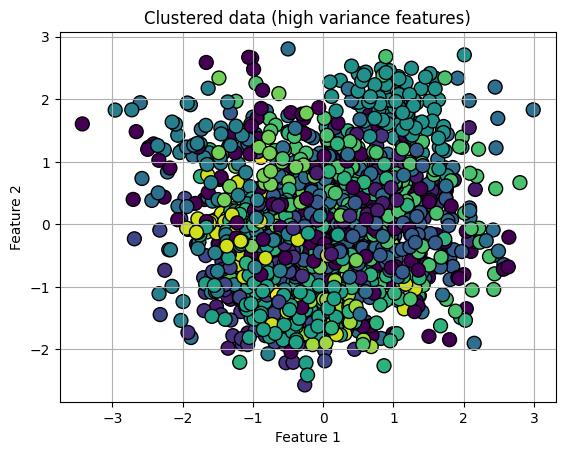

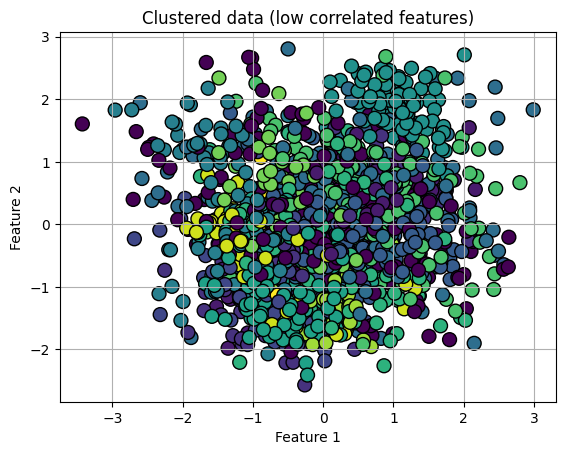

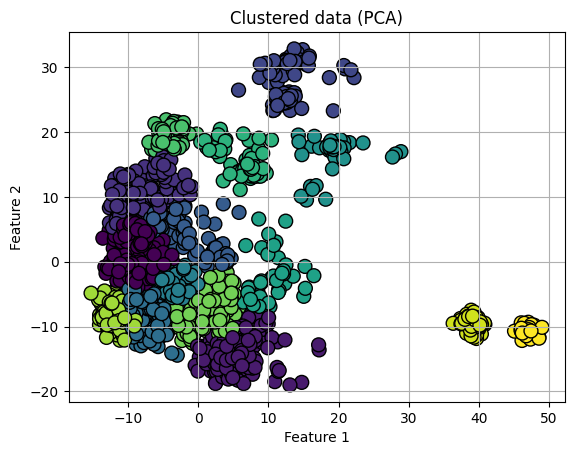

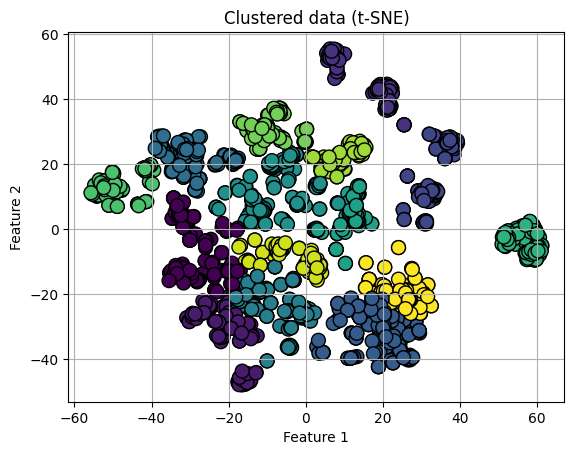

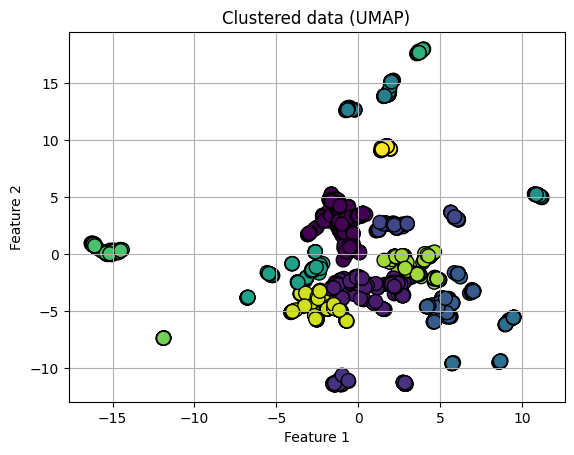

In [71]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering

selector = VarianceThreshold(threshold=(0.8 * (1 - 0.8)))  
X_high_variance = selector.fit_transform(X_scaled)
selected_features = selector.get_support()

hierarchical = AgglomerativeClustering(n_clusters=15)
clusters_high_variance = hierarchical.fit_predict(X_high_variance)
plot_clustering(X_high_variance, clusters_high_variance, 'Clustered data (high variance features)')

correlation_matrix = np.abs(np.corrcoef(X_scaled, rowvar=False))
np.fill_diagonal(correlation_matrix, 0)
max_corr = correlation_matrix.max(axis=1)
mask = max_corr < 0.9  

X_low_corr = X_scaled[:, mask]

clusters_low_corr = hierarchical.fit_predict(X_low_corr)
plot_clustering(X_low_corr, clusters_low_corr, 'Clustered data (low correlated features)')

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
clusters_pca = hierarchical.fit_predict(X_pca)
plot_clustering(X_pca, clusters_pca, 'Clustered data (PCA)')

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
clusters_tsne = hierarchical.fit_predict(X_tsne)
plot_clustering(X_tsne, clusters_tsne, 'Clustered data (t-SNE)')
df["clusters"] = clusters_tsne

reducer = UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)
clusters_UMAP = hierarchical.fit_predict(X_umap)
plot_clustering(X_umap, clusters_UMAP, 'Clustered data (UMAP)')

In [72]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

datasets = [
    (X_high_variance, clusters_high_variance, "High Variance Features"),
    (X_low_corr, clusters_low_corr, "Low Correlated Features"),
    (X_pca, clusters_pca, "PCA"),
    (X_tsne, clusters_tsne, "t-SNE"),
    (X_umap, clusters_UMAP, "UMAP"),
]

print("Silhouette Score | Davies-Bouldin Index | Calinski-Harabasz Index | Technique")
print("-------------------------------------------------------------------------")
for X_transformed, clusters, technique in datasets:
    silhouette = silhouette_score(X_transformed, clusters)
    davies_bouldin = davies_bouldin_score(X_transformed, clusters)
    calinski_harabasz = calinski_harabasz_score(X_transformed, clusters)
    print(f"{silhouette:.4f}          | {davies_bouldin:.4f}              | {calinski_harabasz:.4f}                | {technique}")

Silhouette Score | Davies-Bouldin Index | Calinski-Harabasz Index | Technique
-------------------------------------------------------------------------
0.1269          | 2.6050              | 79.2627                | High Variance Features
0.1267          | 2.6061              | 78.6258                | Low Correlated Features
0.4091          | 0.6959              | 3642.5595                | PCA
0.4395          | 0.7607              | 2265.0952                | t-SNE
0.5581          | 0.5556              | 3630.7808                | UMAP


## Exploring Spectral Clustering

Spectral Clustering wins the immediate award for coolest name out of the algorithms, but also handedly loses the award for best clustering method. Spectral Clustering is best used in cases of complex/non-linear clusters because, as the name implies, it finds hidden, ghost patterns between data points quite well. 

I truly wasn't sure how my data fit into the parameters it worked best with, so I gave it a shot. 

*Also not shown is my many trials with both DBSCAN and HDBSCAN density-based clustering which was so entirely messy that I've left it to stay locked away in the experimentation notebook.*

### Visualization of Clusters

In the visualizations, "Feature 1" and "Feature 2" are arbitrary representations of the combined features in a way that the algorithm deems best for representing the most important aspects of the original dataset and global structures. The exact names for these features don't exist, as they are a result of the dimensionality reduction techniques.

As we continue experimenting with different clustering algorithms, it's essential to choose the one that best meets the requirements of our data and provides meaningful insights.

/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


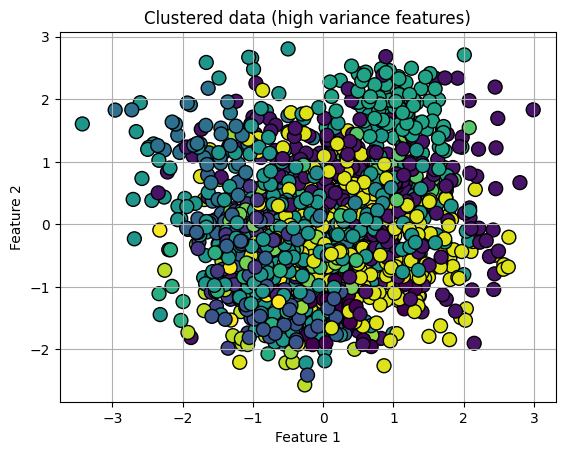

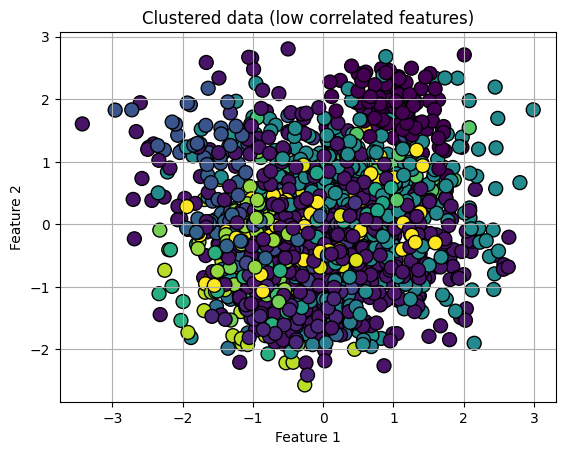

/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


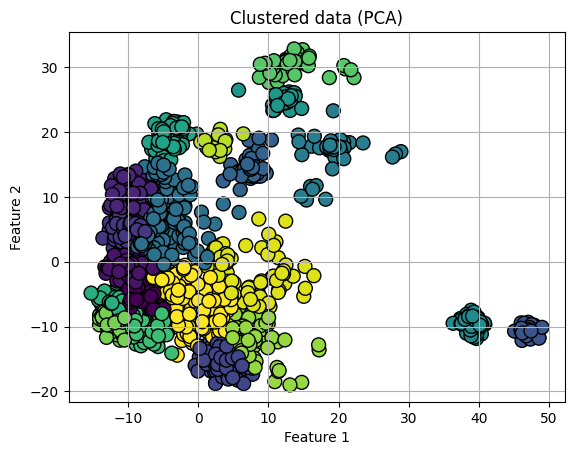

/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


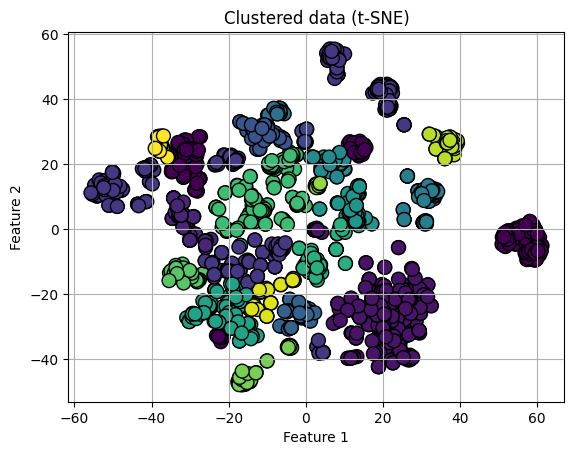

/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


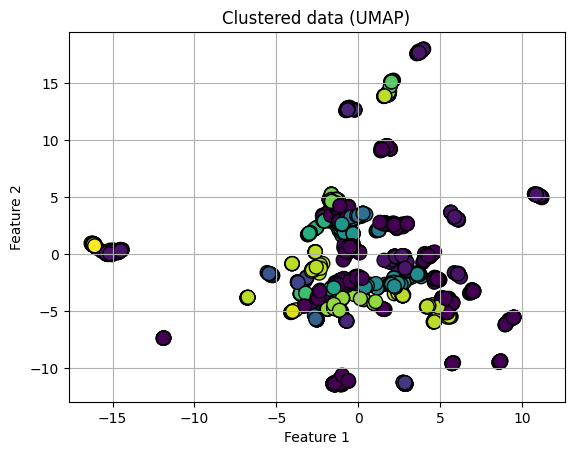

In [74]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
import numpy as np



n_clusters = 15  
spectral= SpectralClustering(n_clusters=20, affinity='nearest_neighbors')

selector = VarianceThreshold(threshold=(0.8 * (1 - 0.8)))  
X_high_variance = selector.fit_transform(X_scaled)
selected_features = selector.get_support()

kmeans = KMeans(n_clusters=25, random_state=42)
clusters_high_variance = spectral.fit_predict(X_high_variance)
plot_clustering(X_high_variance, clusters_high_variance, 'Clustered data (high variance features)')

correlation_matrix = np.abs(np.corrcoef(X_scaled, rowvar=False))
np.fill_diagonal(correlation_matrix, 0)
max_corr = correlation_matrix.max(axis=1)
mask = max_corr < 0.9  

X_low_corr = X_scaled[:, mask]

clusters_low_corr = spectral.fit_predict(X_low_corr)
plot_clustering(X_low_corr, clusters_low_corr, 'Clustered data (low correlated features)')

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
clusters_pca = spectral.fit_predict(X_pca)
plot_clustering(X_pca, clusters_pca, 'Clustered data (PCA)')

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
clusters_tsne = spectral.fit_predict(X_tsne)
plot_clustering(X_tsne, clusters_tsne, 'Clustered data (t-SNE)')


reducer = UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)
clusters_UMAP = spectral.fit_predict(X_umap)
plot_clustering(X_umap, clusters_UMAP, 'Clustered data (UMAP)')



In [75]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

datasets = [
    (X_high_variance, clusters_high_variance, "High Variance Features"),
    (X_low_corr, clusters_low_corr, "Low Correlated Features"),
    (X_pca, clusters_pca, "PCA"),
    (X_tsne, clusters_tsne, "t-SNE"),
    (X_umap, clusters_UMAP, "UMAP"),
]

print("Silhouette Score | Davies-Bouldin Index | Calinski-Harabasz Index | Technique")
print("-------------------------------------------------------------------------")
for X_transformed, clusters, technique in datasets:
    silhouette = silhouette_score(X_transformed, clusters)
    davies_bouldin = davies_bouldin_score(X_transformed, clusters)
    calinski_harabasz = calinski_harabasz_score(X_transformed, clusters)
    print(f"{silhouette:.4f}          | {davies_bouldin:.4f}              | {calinski_harabasz:.4f}                | {technique}")

Silhouette Score | Davies-Bouldin Index | Calinski-Harabasz Index | Technique
-------------------------------------------------------------------------
0.1143          | 1.9751              | 56.5230                | High Variance Features
0.1058          | 1.8648              | 53.3491                | Low Correlated Features
0.3686          | 0.7487              | 3261.6389                | PCA
0.0972          | 3.4658              | 135.1128                | t-SNE
-0.2681          | 4.9292              | 41.1453                | UMAP


## Winner: K-Means with UMAP Dimensionality Reduction

And our winner is... K-Means using UMAP! woohoo! This winning combination of K-Means clustering and UMAP for dimensionality reduction achieved impressive scores given the dataset my playlist had me working with. The scores for the Silhouette Index (SI), Davies-Bouldin Index (BDI), and Calinski-Harabasz Index (CHI) are as follows:

1. **Silhouette Index (SI)**: 0.6069 - A higher score (closer to 1) implies better-defined clusters with good separation and compactness.
2. **Davies-Bouldin Index (BDI)**: 0.5072 - A lower score (closer to 0) indicates better clustering performance with more compact and better-separated clusters.
3. **Calinski-Harabasz Index (CHI)**: 5223.4954 - A higher score represents a better overall clustering performance, with more significant variance between clusters and smaller variance within clusters.

### The Winning Method Revisualized

/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


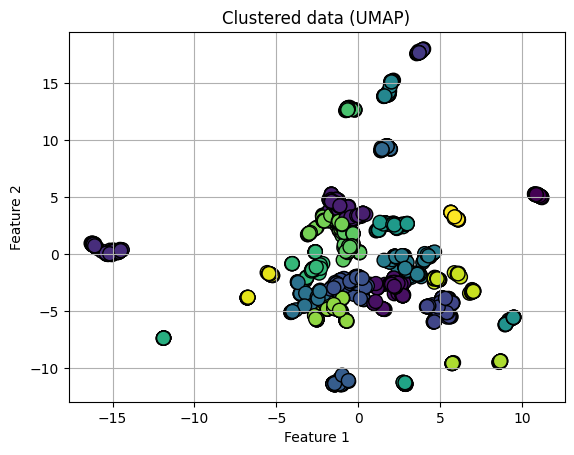

In [77]:
reducer = UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)
clusters_UMAP = kmeans.fit_predict(X_umap)
plot_clustering(X_umap, clusters_UMAP, 'Clustered data (UMAP)')
df_embeddings["cluster"] = clusters_UMAP

# Analyzing and Exploring Clustering Results

After applying the clustering algorithm, we have divided the playlist into 25 distinct clusters. This division is promising because it demonstrates that the clustering algorithm managed to define actual patterns in the data and assign songs to clusters accordingly. Some patterns were more popular than others, indicating a remarkable differentiation between the generated clusters.

In [78]:
cluster_counts = df_embeddings.groupby("cluster").size().reset_index(name="count")
print(cluster_counts)


    cluster  count
0         0     39
1         1    100
2         2    143
3         3    104
4         4     43
5         5    118
6         6    107
7         7     70
8         8     50
9         9    105
10       10    129
11       11     55
12       12     27
13       13     73
14       14     33
15       15     12
16       16     74
17       17     41
18       18     66
19       19    118
20       20     85
21       21     29
22       22     58
23       23     44
24       24     27


In [218]:
for cluster, group in df_embeddings.groupby("cluster"):
    print(f"Cluster {cluster}:")
    print(group["title"].sample(10))
    print("=====================================")


Cluster 0:
1567                                               Phone
1571                                              Nascar
1684                                            i need u
1593    Folie Á Deux (feat. Westside Gunn & Keisha Plum)
1698                                      100 Round Drum
1742                                                FOLD
1598                                            Drakon !
1695                                        Ease My Pain
1569                                              Lately
1184                                        The God Hour
Name: title, dtype: object
Cluster 1:
1632                                       25WAGG3DOU2
304                      Jesus Forgive Me, I Am A Thot
1491                                             On BS
856                                       Fallen Demon
602     Heaven Knows I'm Miserable Now - 2011 Remaster
78                                    Imaginary Places
1590                                        Pepperm

## Calculating Frequencies of Embedded Factors

In this step, I calculate the frequencies of specific embedded factors within each cluster to identify larger, overarching patterns. These patterns were suitable while creating the embeddings, but now it's time to shift our focus towards creativity.

### Reducing Frequency for Creativity

To encourage more creative outputs from the AI model, I aim to remove as much frequency as possible from the data. This enables the AI to focus on more unique aspects rather than getting influenced by the abundance of one particular statistical element.

In [80]:
from collections import Counter
import random

df_embeddings["lyrics"] = df["lyrics"]
df_embeddings["descriptors"] = df["descriptors"]
df_embeddings["genres"] = df["genres"]
columns = ["danceability_normalized", "energy_normalized", "acousticness_normalized", "instrumentalness_normalized", "valence_normalized", "tempo_normalized"]
df_embeddings[columns] = df[columns]
descriptors_list = [value.strip() for row in df_embeddings["descriptors"] for value in row.split(",")]
descriptors_count = Counter(descriptors_list)

genres_list = [value.strip() for row in df_embeddings["genres"] for value in row.split(",")]
genres_count = Counter(genres_list)


print("Descriptors frequencies (top 20):")
for descriptor, count in descriptors_count.most_common(20):
    print(f"{descriptor}: {count}")

print("\nGenres frequencies (top 20):")
for genre, count in genres_count.most_common(20):
    print(f"{genre}: {count}")



Descriptors frequencies (top 20):
Materialism: 752
Hedonism: 457
Aggression: 393
Narcissism: 349
Violence: 346
Ambition: 322
Recklessness: 316
Bravado: 302
Paranoia: 294
Defiance: 290
Rebellion: 287
Braggadocio: 265
Loyalty: 240
Nostalgia: 210
Swagger: 209
Regret: 194
Isolation: 190
Resilience: 186
Longing: 176
Betrayal: 171

Genres frequencies (top 20):
rap: 683
underground hip hop: 679
hip hop: 470
vapor trap: 363
trap: 232
dark trap: 229
plugg: 191
alternative hip hop: 190
pluggnb: 171
emo rap: 116
melodic rap: 115
: 104
psychedelic hip hop: 96
experimental hip hop: 84
atl hip hop: 81
southern hip hop: 80
glitchcore: 74
new orleans rap: 72
pop rap: 69
rock: 69


**The code below printed a lot of information that seemed too spatially expensive given what it displayed, so no output is shown**

In [ ]:
from collections import Counter
import random


N = 10

for i in range(25):
    cluster_df = df_embeddings[df_embeddings["cluster"] == i]
    
    descriptors_list = [value.strip() for row in cluster_df["descriptors"] for value in row.split(",")]
    descriptors_count = Counter(descriptors_list)
    
    genres_list = [value.strip() for row in cluster_df["genres"] for value in row.split(",")]
    genres_count = Counter(genres_list)
    
    danceability_count = Counter(cluster_df["danceability_normalized"])
    energy_count = Counter(cluster_df["energy_normalized"])
    acousticness_count = Counter(cluster_df["acousticness_normalized"])
    instrumentalness_count = Counter(cluster_df["instrumentalness_normalized"])
    valence_count = Counter(cluster_df["valence_normalized"])
    tempo_count = Counter(cluster_df["tempo_normalized"])
    
    print(f"\nCluster {i}:")
    print(f"Top {N} descriptors:")
    for descriptor, count in descriptors_count.most_common(N):
        print(f"- {descriptor}: {count}")
    
    print(f"Top {N} genres:")
    for genre, count in genres_count.most_common(N):
        print(f"- {genre}: {count}")
    
    print(f"Top {N} danceability values:")
    for value, count in danceability_count.most_common(N):
        print(f"- {value}: {count}")
    
    print(f"Top {N} energy values:")
    for value, count in energy_count.most_common(N):
        print(f"- {value}: {count}")
    
    print(f"Top {N} acousticness values:")
    for value, count in acousticness_count.most_common(N):
        print(f"- {value}: {count}")
    
    print(f"Top {N} instrumentalness values:")
    for value, count in instrumentalness_count.most_common(N):
        print(f"- {value}: {count}")
    
    print(f"Top {N} valence values:")
    for value, count in valence_count.most_common(N):
        print(f"- {value}: {count}")
    
    print(f"Top {N} tempo values:")
    for value, count in tempo_count.most_common(N):
        print(f"- {value}: {count}")
    
    print()  

### Removing Dominant Data

To focus on the unique features of each playlist, I remove some of the dominant data common throughout the clusters. This way, when analyzing the textual features, the AI will not constantly refer to shared attributes but instead create an identity and uniqueness of description for each playlist.

In [81]:
to_remove = ["Power", "Desperation ", "Despair", "Loneliness", "Arrogance", "Disillusionment", "Materialism", "Hedonism", "Aggression", "Narcissism", "Violence", "Recklessness", "Ambition", "Defiance", "Bravado", "Paranoia", "Rebellion", "Loyalty", "Braggadocio", "Swagger", "Nostalgia", "Betrayal", "Resilience", "Regret", "Isolation", "Longing", "rap", "underground hip hop", "hip hop", "vapor trap", "trap", "dark trap"]

df_embeddings["descriptors"] = df_embeddings["descriptors"].apply(lambda x: ','.join([value for value in x.split(",") if value.strip() not in to_remove]))

df_embeddings["genres"] = df_embeddings["genres"].apply(lambda x: ','.join([value for value in x.split(",") if value.strip() not in to_remove]))

## Generating Playlist Descriptions with AI

With the unique features and concise textual data prepared for each playlist, we proceed to leverage the AI model to generate playlist descriptions.

### Steps to generate playlist descriptions:

1. **Sample selection**: For each playlist, I gather 50 samples (or the maximum number of samples if a playlist has fewer than 50 songs). 
2. **Aggregate textual details**: For each playlist, compile the textual information from lyrical descriptions, genres, and textually-defined numerical data.
3. **Send data to AI**: The aggregated textual information is sent to the GPT-4 model, a much more complex model capable of a much desired textual nuance.
4. **Generate descriptions**: Instruct the AI to create a meaningful description of the playlist based on the aggregated textual details.

By using AI to generate playlist descriptions, we can effectively capture the essence of each playlist derived from the clustering, highlighting the unique characteristics that set them apart.

In [94]:
playlist_texts = []
for i in range(0, 25):
    cluster_df = df_embeddings[df_embeddings["cluster"] == i].copy()

    cluster_df['audio_features'] = cluster_df.apply(lambda row: f"danceability_normalized: {row['danceability_normalized']} energy_normalized: {row['energy_normalized']} acousticness_normalized: {row['acousticness_normalized']} instrumentalness_normalized: {row['instrumentalness_normalized']} valence_normalized: {row['valence_normalized']} tempo_normalized: {row['tempo_normalized']}", axis=1)

    n_samples = min(len(cluster_df), 50)
    sample_df = cluster_df.sample(n=n_samples)

    songs = []
    for _, row in sample_df.iterrows():
        song_str = ""
        song_str += row["descriptors"] + " "
        song_str += row["audio_features"]
        songs.append(song_str)
    
    playlist_text = " ".join(songs)

    playlist_texts.append(playlist_text)


    playlist_texts.append(playlist_text)

    

In [97]:
import openai
import concurrent.futures
def create_descriptor(playlist_text, i):
    response = openai.ChatCompletion.create(
        model='gpt-4',
        messages=[
            {"role": "system", "content": "You are a helpful and an artistically gifted, creative speaker, here to help with any questions I may have."},
            {"role": "user", "content": f"Take this conjoined block of lyrical descriptors, song genres, and audio descriptors for a specific playlist: {playlist_text}. Translate specific emotional sentiments, dominant audio features, and prominent genres of the playlist into a detailed, well-rounded description. Absolutely do not call it a mix, or eclectic, or a concotion, or any other mixture of things. Discover 1-2 specific patterns or features and write directly on those. Each playlist must be 100% unique in its identity, not a variety."}
        ],
        temperature=0.7,
        max_tokens=1500,
    )
    return i, response["choices"][0]["message"]["content"]

descriptions = [None] * len(playlist_texts)

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(create_descriptor, playlist_text.strip(), i) for i, playlist_text in enumerate(playlist_texts)]
    for future in concurrent.futures.as_completed(futures):
        i, descriptor = future.result()
        descriptions[i] = descriptor

with open('playlist_descriptions.txt', 'w') as f:
    for i, description in enumerate(descriptions):
        f.write(f"\n\nResponse for playlist {i+1}:\n{description}\n")


## Generating Refined Descriptions with AI and Artist Styles

Here, the generated description is then further refined, but in a super cool way:

1. **Pick a renowned visual artist**: First, I've compiled a list of 100 or so celebrated visual artist, and one names is randomly selected for each playlist.
2. **Create a prompt**: Then I build a prompt incorporating the previously generated playlist description alongside the randomly selected artist's name which will serve as a stylistic guide for the AI.
3. **Send the prompt to AI**: Then each prompt is finally sent to the API with instructions to create its own version of an AI prompt that reflects the artist's style and the playlist's attributes.

In [ ]:
artists = [
    "Leonardo da Vinci in the style of Italian Renaissance",
    "Michelangelo Buonarroti in the style of Italian Renaissance",
    "Pablo Picasso in the style of Cubism and Surrealism",
    "Vincent van Gogh in the style of Post-Impressionism",
    "Rembrandt van Rijn in the style of Dutch Golden Age",
    "Salvador Dalí in the style of Surrealism",
    "Frida Kahlo in the style of Mexican Folk Art and Surrealism",
    "Georgia O'Keeffe in the style of American Modernism",
    "Jackson Pollock in the style of Abstract Expressionism",
    "Claude Monet in the style of Impressionism",
    "Henri Matisse in the style of Fauvism and Modernism",
    "Johannes Vermeer in the style of Dutch Golden Age",
    "Piet Mondrian in the style of De Stijl and Abstract Art",
    "Caravaggio in the style of Baroque",
    "Peter Paul Rubens in the style of Baroque",
    "Diego Velázquez in the style of Baroque",
    "Francisco Goya in the style of Romanticism",
    "Edouard Manet in the style of Realism and Impressionism",
    "Paul Cézanne in the style of Post-Impressionism",
    "Auguste Rodin in the style of Sculpture and Modernism",
    "Katsushika Hokusai in the style of Ukiyo-e and Japanese Art",
    "Titian in the style of Italian Renaissance",
    "Raphael Sanzio in the style of Italian Renaissance",
    "Sandro Botticelli in the style of Italian Renaissance",
    "Henri Cartier-Bresson in the style of Photography and Documentary",
    "Édgar Degas in the style of Impressionism",
    "Gustave Courbet in the style of Realism",
    "Frida Kahlo in the style of Surrealism and Mexican Art",
    "Marcel Duchamp in the style of Dada and Conceptual Art",
    "Marc Chagall in the style of Cubism and Expressionism",
    "Wassily Kandinsky in the style of Expressionism and Abstract Art",
    "Giotto di Bondone in the style of Italian Gothic",
    "Mary Cassatt in the style of Impressionism",
    "Egon Schiele in the style of Expressionism and Austrian Art",
    "Edward Hopper in the style of American Realism and American Scene Painting",
    "Lucian Freud in the style of Expressionism and Portraiture",
    "Artemisia Gentileschi in the style of Baroque",
    "Yayoi Kusama in the style of Pop Art and Contemporary Art",
    "Henri de Toulouse-Lautrec in the style of Post-Impressionism",
    "Max Ernst in the style of Dadaism, Surrealism, and Maximalism",
    "James Whistler in the style of American Art and Painting",
    "Kazimir Malevich in the style of Suprematism",
    "Willem de Kooning in the style of Abstract Expressionism and Dutch-American Art",
    "Cindy Sherman in the style of Photography and Conceptual Art",
    "Jan Van Eyck in the style of Flemish Renaissance",
    "Paul Klee in the style of Abstract Art, Modernism, and Expressionism",
    "Roy Lichtenstein in the style of Pop Art",
    "Hans Holbein the Younger in the style of German Renaissance",
    "Donatello in the style of Italian Renaissance Sculpture",
    "Josef Albers in the style of Abstract Art, Bauhaus, and Geometric Abstraction"
]

In [ ]:
import openai
import concurrent.futures


def generate_art_prompt(description):
    try:
        artist = random.choice(artists)
        artists.remove(artist)
        response = openai.ChatCompletion.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are an eloquent musical bot trained to analyze the emotional sentiment and atmosphere of a playlist."},
                {"role": "user", "content": f"Based on this playlist description: {description}, Give a one paragraph prompt for a visual art piece that you feels represents its overarching emotional sentiment and themes. For the art, specify that it is done by {artist}. Then offer a subject matter to be created in their exact style. Be as specific and complete as possible with your description. Give only concrete visual elements (medium, technique, colors, subject matter, scene, etc.) that are not up for interpretation."}
            ],
            temperature=1,
            max_tokens=3000
        )
        art_prompt = response["choices"][0]["message"]["content"].strip()
        return art_prompt
    except Exception as e:
        print(f"Error generating response for playlist text: {description}")
        print(e)
        return None

def save_to_txt(art_prompts, file_name="art_prompts.txt"):
    with open(file_name, "w", encoding="utf-8") as f:
        for prompt in art_prompts:
            f.write(prompt + "\n\n")

art_prompts = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    future_results = {executor.submit(generate_art_prompt, description): description for description in descriptions}

    for future in concurrent.futures.as_completed(future_results):
        input_description = future_results[future]
        try:
            art_prompt = future.result()
            if art_prompt is not None:
                art_prompts.append(art_prompt)
        except Exception as e:
            print(f"Error processing response for playlist text: {input_description}")
            print(e)
            
save_to_txt(art_prompts)

## Generating Custom Spotify Cover Art with DALL-E

To create personalized and visually appealing cover art for each playlist, we utilize OpenAI's DALL-E to generate images using the AI-generated prompts that incorporate both the playlist's unique characteristics and the style of a renowned visual artist. This approach allows us to create cover art that is specifically tailored to the contents of each playlist while maintaining a unique visual identity through the provided random style inspiration.

Cover art for the playlists serve as a kind of cherry on top as they only serve to complement each playlist's musical themes. All the covert art images, both the trial runs and the final ones used for the playlists, will be at the bottom.

In [ ]:
import openai


def generate_images(prompts):
    for prompt in prompts:
        response = openai.Image.create(
            prompt=prompt,
            n=1,  
            size="1024x1024"
        )
        for image_data in response['data']:
            image_url = image_data['url']
            print(f"Prompt: {prompt}\nImage URL: {image_url}\n")
    return

generate_images(art_prompts)

# Saving Playlists to CSV and Creating Playlists on Spotify

Now that the playlists have been properly divvyed up and artistically imbued, it's time to save each playlist's song and feature information to CSV files and create the playlists automatically using the Spotify API.



In [ ]:
import os

output_dir = "cluster_csvs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i in range(0, 25):
    cluster_df = df_embeddings[df_embeddings["cluster"] == i]
    cluster_df["track_id"] = df["track_id"]
    cluster_csv_filename = f"cluster_{i}.csv"
    cluster_csv_filepath = os.path.join(output_dir, cluster_csv_filename)
    cluster_df.to_csv(cluster_csv_filepath, index=False)

In [109]:
import os
import pandas as pd
from tqdm import tqdm
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
from pprint import pprint
from spotipy.client import SpotifyException
import base64



auth_manager = SpotifyOAuth(client_id=CLIENT_ID,
                            client_secret=CLIENT_SECRET,
                            redirect_uri=REDIRECT_URI,
                            scope=SCOPE,
                            )
sp = spotipy.Spotify(auth_manager=auth_manager, auth=access_token)




csv_directory = "/Users/gavinmason/RawC/Jupyter/Botify/cluster_csvs"

csv_files = [f for f in os.listdir(csv_directory) if f.endswith(".csv")]

for csv_file in csv_files:
    file_path = os.path.join(csv_directory, csv_file)
    df = pd.read_csv(file_path)
    track_uris = df['track_id'].tolist()

    playlist_name = f"T2 {csv_file[:-4]}" 
    try:
        playlist = sp.user_playlist_create(user=sp.current_user()['id'], name=playlist_name, public=False)
        for i in range(0, len(track_uris), 100):
            sp.playlist_add_items(playlist_id=playlist['id'], items=track_uris[i:i+100])
    except SpotifyException as e:
        print(f"Error creating playlist: {e}")
        continue
    print(f"Playlist '{playlist_name}' created with {len(track_uris)} tracks.")

Playlist 'T2 cluster_9' created with 105 tracks.
Playlist 'T2 cluster_8' created with 50 tracks.
Playlist 'T2 cluster_20' created with 85 tracks.
Playlist 'T2 cluster_21' created with 29 tracks.
Playlist 'T2 cluster_23' created with 44 tracks.
Playlist 'T2 cluster_22' created with 58 tracks.
Playlist 'T2 cluster_19' created with 118 tracks.
Playlist 'T2 cluster_18' created with 66 tracks.
Playlist 'T2 cluster_24' created with 27 tracks.
Playlist 'T2 cluster_15' created with 12 tracks.
Playlist 'T2 cluster_14' created with 33 tracks.
Playlist 'T2 cluster_16' created with 74 tracks.
Playlist 'T2 cluster_17' created with 41 tracks.
Playlist 'T2 cluster_13' created with 73 tracks.
Playlist 'T2 cluster_12' created with 27 tracks.
Playlist 'T2 cluster_10' created with 129 tracks.
Playlist 'T2 cluster_11' created with 55 tracks.
Playlist 'T2 cluster_5' created with 118 tracks.
Playlist 'T2 cluster_4' created with 43 tracks.
Playlist 'T2 cluster_6' created with 107 tracks.
Playlist 'T2 cluster

# Playlists Made!!!!

### They can all be viewed publicly here:

*https://open.spotify.com/user/jordynmason?si=11a0e7cb63b145a0*

#### *Down below I will display, in larger form, all of the AI generated art that was created throughout this process. About half were not used due to personal preference or just trial and error of my system.*

In [18]:
import cloudinary
import cloudinary.api
import cloudinary.uploader

cloudinary.config(
    cloud_name="",
    api_key="",
    api_secret="",
    secure=True,
)

In [28]:
def save_images_to_html(image_urls, output_filename="images.html"):
    html = "<!DOCTYPE html>\n<html>\n<head>\n<title>Images</title>\n</head>\n<body>\n"

    for image_url in image_urls:
        html += f'<img src="{image_url}" alt="Image" style="width: 300px; height: auto; padding: 10px;">\n'

    html += "</body>\n</html>"

    with open(output_filename, "w") as f:
        f.write(html)

    print(f"HTML file with images saved as {output_filename}")

save_images_to_html(image_urls)


HTML file with images saved as images.html


In [31]:
from IPython.display import display, Image
def display_images(image_urls):
    for image_url in image_urls:
        display(Image(url=image_url, width=600))
display_images(image_urls)